<h1>Imports, class definitions, initial data cleaning

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
import networkx as nx
from networkx.drawing.nx_agraph import to_agraph
# import pygraphviz as pgv
# import networkx as nx
# from graphviz import Source
# from networkx.drawing.nx_agraph import graphviz_layout
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.preprocessing import StandardScaler
from datetime import date
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from scipy.spatial import distance
import warnings
import math


plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 150
pd.options.mode.chained_assignment = None
warnings.filterwarnings("ignore")

In [2]:
class EloRating:
    def __init__(self, k_factor=32):
        self.k_factor = k_factor
        self.ratings = {}

    def add_fighter(self, fighter):
        self.ratings[fighter] = 1500  # Initial rating for a new player

    def get_rating(self, fighter):
        return self.ratings.get(fighter)

    def calculate_expected_score(self, rating_a, rating_b):
        return 1 / (1 + 10 ** ((rating_b - rating_a) / 400))
    
    def get_autocorrelated_multiplier(self, rating1, rating2):
        if (rating2 > rating1):
            return 1 / (1 - ((rating1 - rating2) / 2200))
        else:
            return 1 / (1 - ((rating2 - rating1) / 2200))
        
    def get_win_multiplier(self, win_method):
        if 'DEC' in win_method:
            if 'M' in win_method:
                return 2
            elif 'U' in win_method:
                return 3
            else:
                return 1
        elif ('KO' in win_method or 'SUB' in win_method):
            return 5
        else:
            return 1
        
    def update_ratings(self, fighter1, fighter2, outcome1, outcome2, w_m):
        rating1 = self.get_rating(fighter1)
        rating2 = self.get_rating(fighter2)
        
        a_m = self.get_autocorrelated_multiplier(rating1,rating2)

        expected_score_fighter1 = self.calculate_expected_score(rating1, rating2)
        expected_score_fighter2 = self.calculate_expected_score(rating2, rating1)
        
        if (outcome1 == 0 and outcome2 == 0):
            # if there is a draw and one fighter has a higher rating than another, change rating accordingly
            if rating1 > rating2:
                outcome2 = 1
            elif rating1 < rating2:
                outcome1 = 1
            else:
                # there will not be a change in rating if they drew and the ratings are the same
                return [rating]
            
        rating1_new = rating1 + self.k_factor * w_m * a_m * (outcome1 - expected_score_fighter1)
        rating2_new = rating2 + self.k_factor * w_m * a_m * (outcome2 - expected_score_fighter2)

        self.ratings[fighter1] = rating1_new
        self.ratings[fighter2] = rating2_new
        
        # return the prefight elo ratings to use for ML
        return [rating1, rating2]

In [3]:
df = pd.read_csv('masterdataframe.csv')

In [4]:
df.info(verbose=True,show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4086 entries, 0 to 4085
Data columns (total 530 columns):
 #    Column                                                     Non-Null Count  Dtype  
---   ------                                                     --------------  -----  
 0    date                                                       4086 non-null   object 
 1    fight_url                                                  4086 non-null   object 
 2    event_url                                                  4086 non-null   object 
 3    result                                                     4086 non-null   int64  
 4    fighter                                                    4086 non-null   object 
 5    opponent                                                   4086 non-null   object 
 6    division                                                   4086 non-null   object 
 7    stance                                                     4040 non-null   object 
 8

In [5]:
df = df[["date",
"fight_url",
"event_url",
"result",
"fighter",
"opponent",
"division",
"stance",
"dob",
"method",
"total_comp_time",
"round",
"time",
"fighter_url",
"opponent_url",
"referee",
"time_format",
"reach",
"height",
"age",
"knockdowns",
"sub_attempts",
"reversals",
"control",
"takedowns_landed",
"takedowns_attempts",
"sig_strikes_landed",
"sig_strikes_attempts",
"total_strikes_landed",
"total_strikes_attempts",
"head_strikes_landed",
"head_strikes_attempts",
"body_strikes_landed",
"body_strikes_attempts",
"leg_strikes_landed",
"leg_strikes_attempts",
"distance_strikes_landed",
"distance_strikes_attempts",
"clinch_strikes_landed",
"clinch_strikes_attempts",
"ground_strikes_landed",
"ground_strikes_attempts",
"takedowns_accuracy",
"sig_strikes_accuracy",
"total_strikes_accuracy",
"head_strikes_accuracy",
"body_strikes_accuracy",
"leg_strikes_accuracy",
"distance_strikes_accuracy",
"clinch_strikes_accuracy",
"ground_strikes_accuracy",
"takedowns_def",
"sig_strikes_def",
"total_strikes_def",
"head_strikes_def",
"body_strikes_def",
"leg_strikes_def",
"distance_strikes_def",
"clinch_strikes_def",
"ground_strikes_def"]]

In [6]:
df['date'] = pd.to_datetime(df['date'])
df['fighter'] = df['fighter'].str.lower()
df['opponent'] = df['opponent'].str.lower()

df['age'] = df['age'].fillna(np.mean(df['age']))
df['height'] = df['height'].fillna(np.mean(df['height']))
df['reach'] = df['reach'].fillna(np.mean(df['reach']))
df['stance'] = df['stance'].fillna(df[['stance']].groupby(by = 'stance').size().idxmax())

In [7]:
df.info(verbose=True,show_counts = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4086 entries, 0 to 4085
Data columns (total 60 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   date                       4086 non-null   datetime64[ns]
 1   fight_url                  4086 non-null   object        
 2   event_url                  4086 non-null   object        
 3   result                     4086 non-null   int64         
 4   fighter                    4086 non-null   object        
 5   opponent                   4086 non-null   object        
 6   division                   4086 non-null   object        
 7   stance                     4086 non-null   object        
 8   dob                        3851 non-null   object        
 9   method                     4086 non-null   object        
 10  total_comp_time            4086 non-null   int64         
 11  round                      4086 non-null   int64         
 12  time  

In [8]:
df.head()

,date,fight_url,event_url,result,fighter,opponent,division,stance,dob,method,...,ground_strikes_accuracy,takedowns_def,sig_strikes_def,total_strikes_def,head_strikes_def,body_strikes_def,leg_strikes_def,distance_strikes_def,clinch_strikes_def,ground_strikes_def
0,1994-03-11,http://ufcstats.com/fight-details/4acab67848e7...,http://ufcstats.com/event-details/a6a9ab5a824e...,0,sean daugherty,scott morris,Open Weight,Orthodox,1975-12-04,SUB,...,0.0,0.0,0.000000,0.000000,0.0,100.0,100.0,100.0,0.0,100.0
1,1994-03-11,http://ufcstats.com/fight-details/4acab67848e7...,http://ufcstats.com/event-details/a6a9ab5a824e...,1,scott morris,sean daugherty,Open Weight,Orthodox,NaN,SUB,...,0.0,100.0,100.000000,80.000000,100.0,100.0,100.0,100.0,100.0,100.0
2,1994-03-11,http://ufcstats.com/fight-details/4b9ae533ccb3...,http://ufcstats.com/event-details/a6a9ab5a824e...,0,ray wizard,patrick smith,Open Weight,Orthodox,NaN,SUB,...,0.0,100.0,0.000000,0.000000,100.0,0.0,100.0,100.0,0.0,100.0
3,1994-03-11,http://ufcstats.com/fight-details/4b9ae533ccb3...,http://ufcstats.com/event-details/a6a9ab5a824e...,1,patrick smith,ray wizard,Open Weight,Orthodox,1963-08-28,SUB,...,0.0,100.0,0.000000,0.000000,100.0,100.0,0.0,0.0,100.0,100.0
4,1994-03-11,http://ufcstats.com/fight-details/ccee020be2e8...,http://ufcstats.com/event-details/a6a9ab5a824e...,0,david levicki,johnny rhodes,Open Weight,Orthodox,NaN,KO/TKO,...,100.0,0.0,35.294118,13.953488,40.0,0.0,0.0,0.0,0.0,40.0


In [558]:
df = df.sort_values(by = ['date','fight_url'])

In [559]:
df = df.reset_index(drop = True)

In [543]:
# save cluster data before creating prefight metrics
cluster = df.copy()

In [546]:
test = df.groupby('fighter')[np.concatenate((['total_comp_time'],list(df.columns[20:])))].transform(lambda x: x.rolling(len(x), min_periods = 1, closed = 'left').mean())

In [547]:
# add recent prefight avg metrics
test_recent = df.groupby('fighter')[np.concatenate((['total_comp_time'],list(df.columns[20:])))].transform(lambda x: x.rolling(3, min_periods = 1, closed = 'left').mean())

In [548]:
df = df.merge(test.add_prefix('prefight_ave_'),left_index = True, right_index = True)
df = df.merge(test_recent.add_prefix('prefight_recent_ave_'),left_index = True, right_index=True)

In [549]:
df = df[np.concatenate((['fight_url','date','fighter','opponent','result','division','stance','method','age','reach','height'],list(df.columns[60:])))].fillna(0.0)

In [503]:
if (len(df)//2)%2 == 1:
    df_split = len(df)//2 + 1
else:
    df_split = len(df)//2

In [505]:
lose_df = df[(df['method'] != 'DRAW')&(df['result'] == 0)&(df.index>=df_split)]
win_df = df[(df['method'] != 'DRAW')&(df['result'] == 1)&(df.index>=df_split)].drop(columns = ['date','fighter','opponent','division','method'])
win_df = win_df.add_prefix('opponent_')
intermediate_analysis_df1 = lose_df.merge(win_df, how = 'left', left_on = 'fight_url', right_on = 'opponent_fight_url')

In [509]:
len(intermediate_analysis_df1)

1005

In [506]:
win_df = df[(df['method'] != 'DRAW')&(df['result'] == 1)&(df.index<df_split)]
lose_df = df[(df['method'] != 'DRAW')&(df['result'] == 0)&(df.index<df_split)].drop(columns = ['date','fighter','opponent','division','method'])
lose_df = lose_df.add_prefix('opponent_')
intermediate_analysis_df2 = win_df.merge(lose_df, how = 'left', left_on = 'fight_url', right_on = 'opponent_fight_url')

In [507]:
len(intermediate_analysis_df2)

1009

In [307]:
draw_df1 = df[(df['method'] == 'DRAW')].iloc[0::2, :]
draw_df2 = df[(df['method'] == 'DRAW')].iloc[1::2, :].drop(columns = ['date','fighter','opponent','division','method'])
draw_df2 = draw_df2.add_prefix('opponent_')
intermediate_analysis_df3 = draw_df1.merge(draw_df2, how = 'left', left_on = 'fight_url', right_on = 'opponent_fight_url')

In [510]:
len(intermediate_analysis_df3)

29

In [511]:
intermediate_analysis_df = pd.concat([intermediate_analysis_df1,intermediate_analysis_df2,intermediate_analysis_df3])

In [512]:
len(intermediate_analysis_df)

2043

In [513]:
intermediate_analysis_df

,fight_url,date,fighter,opponent,result,division,stance,method,age,reach,...,opponent_prefight_ave_ground_strikes_accuracy,opponent_prefight_ave_takedowns_def,opponent_prefight_ave_sig_strikes_def,opponent_prefight_ave_total_strikes_def,opponent_prefight_ave_head_strikes_def,opponent_prefight_ave_body_strikes_def,opponent_prefight_ave_leg_strikes_def,opponent_prefight_ave_distance_strikes_def,opponent_prefight_ave_clinch_strikes_def,opponent_prefight_ave_ground_strikes_def
0,http://ufcstats.com/fight-details/539eff1fe2fb...,2008-12-27,reese andy,matt hamill,0,Light Heavyweight,Orthodox,KO/TKO,49.0,73.276261,...,70.015949,100.000000,61.235283,52.566456,75.384555,22.457265,8.021978,61.970110,64.930556,77.777778
1,http://ufcstats.com/fight-details/59e653313c87...,2008-12-27,mike wessel,antoni hardonk,0,Heavyweight,Orthodox,KO/TKO,44.0,73.276261,...,0.000000,38.000000,56.376526,36.984848,58.969697,80.000000,60.000000,65.151515,66.666667,44.000000
2,http://ufcstats.com/fight-details/8add23232cdb...,2008-12-27,dan evensen,pat barry,0,Heavyweight,Orthodox,KO/TKO,48.0,73.276261,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,http://ufcstats.com/fight-details/b3f4583109b4...,2008-12-27,mostapha al-turk,cheick kongo,0,Heavyweight,Orthodox,KO/TKO,48.0,77.000000,...,51.240496,46.190476,54.327666,30.034425,69.870130,29.246547,66.071429,82.313739,67.857143,46.939655
4,http://ufcstats.com/fight-details/b8927a3a2735...,2008-12-27,mike massenzio,cb dollaway,0,Middleweight,Southpaw,KO/TKO,39.0,73.000000,...,41.666667,83.333333,64.615385,37.500000,90.909091,16.666667,50.000000,80.000000,62.500000,92.857143
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24,http://ufcstats.com/fight-details/1c0bf66167c9...,2012-06-23,milton vieira,felipe arantes,0,Featherweight,Orthodox,DRAW,43.0,73.276261,...,66.071429,50.000000,66.754651,51.944628,76.195259,29.166667,35.000000,73.035714,16.666667,45.238095
25,http://ufcstats.com/fight-details/93ffadd9e41a...,2012-07-21,francisco rivera,roland delorme,0,Bantamweight,Orthodox,DRAW,40.0,70.000000,...,93.750000,50.000000,42.782678,37.916667,51.899510,6.250000,0.000000,56.862745,9.375000,0.000000
26,http://ufcstats.com/fight-details/ccacbe6a4c31...,2012-07-21,matthew riddle,chris clements,0,Welterweight,Southpaw,DRAW,36.0,76.000000,...,84.615385,50.000000,39.130435,32.307692,39.534884,33.333333,100.000000,48.571429,100.000000,9.090909
27,http://ufcstats.com/fight-details/7e27d9f37c21...,2012-08-04,wagner prado,phil davis,0,Light Heavyweight,Southpaw,DRAW,35.0,74.000000,...,51.163194,87.500000,78.221789,70.018859,85.027776,63.888889,46.666667,80.822445,69.444444,87.037037


<h1>Adding Complemetary Data

<h2>fighter's home country

In [710]:
ht = pd.read_csv('pro_mma_fighters.csv')

In [711]:
countryChangeMap = {
    'indies': 'india',
    'usa': 'united states',
    'wales': 'united kingdom',
    'scotland':'united kingdom',
    'england': 'united kingdom',
    'unkown' : 'world',
    'unknown':'world',
    'northern ireland': 'ireland',
    'macedonia':'albania',
    "cote d'ivoire":'ghana',
    'congo, the democratic republic of the':'congo',
    'brunei darussalam':'brunei'
}

In [712]:
ht = ht[['fighter_name','country']]
ht['country'] = ht['country'].astype(str).str.lower()
ht['fighter_name'] = ht['fighter_name'].astype(str).str.lower()
ht['country'] = ht["country"].apply(lambda x: countryChangeMap.get(x) if countryChangeMap.get(x) else x)
ht = ht.drop_duplicates()
ht = ht.drop(2583) # two cases of one fighter having two different home countries
ht = ht.drop(2591)

In [714]:
intermediate_analysis_df = intermediate_analysis_df.merge(ht.rename(columns = {'fighter_name': 'fighter'}),how = 'left',on = 'fighter')
intermediate_analysis_df = intermediate_analysis_df.rename(columns = {'country':'fighter_country'})

In [716]:
intermediate_analysis_df = intermediate_analysis_df.merge(ht.rename(columns = {'fighter_name': 'opponent'}),how = 'left',on = 'opponent')
intermediate_analysis_df = intermediate_analysis_df.rename(columns = {'country':'opponent_country'})

In [718]:
intermediate_analysis_df['fighter_country'] = intermediate_analysis_df['fighter_country'].fillna(intermediate_analysis_df[['fighter_country']].groupby(by = 'fighter_country').size().idxmax())
intermediate_analysis_df['opponent_country'] = intermediate_analysis_df['opponent_country'].fillna(intermediate_analysis_df[['opponent_country']].groupby(by = 'opponent_country').size().idxmax())

<h2>Get GDP of home country

In [720]:
# 2021 gdp data
gdp = pd.read_csv("country_gdp.csv")

In [721]:
gdp = gdp[['Country/Territory','World Bank']]
gdp = gdp.rename(columns = {'Country/Territory':'country','World Bank':'GDP'})
gdp['country'] = gdp['country'].astype(str).str.lower()

In [723]:
intermediate_analysis_df=intermediate_analysis_df.merge(gdp.rename(columns = {'country':'fighter_country'}),how='left',on = 'fighter_country')
intermediate_analysis_df = intermediate_analysis_df.rename(columns = {'GDP':'fighter_utdGDP'})
intermediate_analysis_df=intermediate_analysis_df.merge(gdp.rename(columns = {'country':'opponent_country'}),how='left',on = 'opponent_country')
intermediate_analysis_df = intermediate_analysis_df.rename(columns = {'GDP':'opponent_utdGDP'})                               

<h2>Get Betting odds of the fight

In [725]:
odds = pd.read_csv('gambling_odds.csv')

In [726]:
odds['date'] = pd.to_datetime(odds['date'])
odds['R_fighter'] = odds['R_fighter'].astype(str).str.lower()
odds['B_fighter'] = odds['B_fighter'].astype(str).str.lower()
odds = odds.drop(columns = ['location','country','Winner','title_bout','weight_class','gender'])

In [728]:
intermediate_analysis_df = intermediate_analysis_df.merge(odds.rename(columns={'R_fighter':'fighter','B_fighter':'opponent'}),how='left',on = ['fighter','opponent','date'])
intermediate_analysis_df = intermediate_analysis_df.merge(odds.rename(columns={'R_fighter':'opponent','B_fighter':'fighter'}),how='left',on = ['fighter','opponent','date'])

In [730]:
intermediate_analysis_df['fighter_odds'] = intermediate_analysis_df['R_odds_x'].combine_first(intermediate_analysis_df['R_odds_y'])
intermediate_analysis_df['opponent_odds'] = intermediate_analysis_df['B_odds_x'].combine_first(intermediate_analysis_df['B_odds_y'])

In [732]:
intermediate_analysis_df = intermediate_analysis_df.drop(columns = ['R_odds_x','R_odds_y','B_odds_x','B_odds_y'])

In [745]:
t = pd.concat([intermediate_analysis_df[['fighter','fighter_odds']],intermediate_analysis_df[['opponent','opponent_odds']].rename(columns = {'opponent':'fighter','opponent_odds':'fighter_odds'})])

In [752]:
t = t.groupby('fighter')['fighter_odds'].mean().dropna()

In [755]:
intermediate_analysis_df = intermediate_analysis_df.merge(t,right_index = True, left_on = 'fighter',how='left')

In [756]:
intermediate_analysis_df['fighter_odds'] = intermediate_analysis_df['fighter_odds_x'].combine_first(intermediate_analysis_df['fighter_odds_y'])

In [767]:
t = t.rename_axis('opponent')
t.name = 'opponent_odds'

In [769]:
intermediate_analysis_df = intermediate_analysis_df.merge(t,right_index = True, left_on = 'opponent',how='left')

In [771]:
intermediate_analysis_df['opponent_odds'] = intermediate_analysis_df['opponent_odds_x'].combine_first(intermediate_analysis_df['opponent_odds_y'])

In [774]:
intermediate_analysis_df = intermediate_analysis_df.drop(columns = ['fighter_odds_x','fighter_odds_y','opponent_odds_x','opponent_odds_y'])

In [776]:
intermediate_analysis_df['fighter_odds'] = intermediate_analysis_df['fighter_odds'].fillna(np.mean(intermediate_analysis_df['fighter_odds']))

In [777]:
intermediate_analysis_df['opponent_odds'] = intermediate_analysis_df['opponent_odds'].fillna(np.mean(intermediate_analysis_df['opponent_odds']))

In [778]:
intermediate_analysis_df.info(verbose=True,show_counts = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6661 entries, 0 to 6660
Data columns (total 105 columns):
 #    Column                                           Non-Null Count  Dtype         
---   ------                                           --------------  -----         
 0    fight_url                                        6661 non-null   object        
 1    date                                             6661 non-null   datetime64[ns]
 2    fighter                                          6661 non-null   object        
 3    opponent                                         6661 non-null   object        
 4    result                                           6661 non-null   int64         
 5    division                                         6661 non-null   object        
 6    stance                                           6661 non-null   object        
 7    method                                           6661 non-null   object        
 8    age                       

<h1>Feature Engineering

In [779]:
# elo algorithm

    # initialize the starting ELO based something other than static number
    # assign multiplier for unan dec, split dec, finish sub, finish ko, finish tko
    # autocorrelation factor penalty
    
# style of a fighter - clustering

# feautre engineering potentially
# recent avg - done above : test_recent rolling calc

# days since last fight
# fight up a weight/down a weight flag
# win streak/loss streak



<h2>ELO score

In [50]:
to_elo = intermediate_analysis_df[['date','fight_url','fighter','opponent','result','opponent_result','method']].reset_index(drop = True)
to_elo['prefight_elo'] = 0
to_elo['opponent_prefight_elo'] = 0

In [53]:
elo_scorer = EloRating() # import the class if not in this nb
for fighter in set(pd.concat([to_elo['fighter'],to_elo['opponent']])):
    elo_scorer.add_fighter(fighter)

In [54]:
for row in to_elo.itertuples():
    w_m = elo_scorer.get_win_multiplier(row.method)
    prefight_elo = elo_scorer.update_ratings(row.fighter, row.opponent, row.result, row.opponent_result,w_m)
    to_elo.loc[row.Index,'prefight_elo'] = prefight_elo[0]
    to_elo.loc[row.Index,'opponent_prefight_elo'] = prefight_elo[1]

In [58]:
to_elo[to_elo['fighter'] == 'jon jones'].drop(columns = ['fight_url'])

,date,fighter,opponent,result,opponent_result,method,prefight_elo,opponent_prefight_elo
4201,2008-08-09,jon jones,andre gusmao,1,0,U-DEC,1775.164147,1500.000000
4299,2009-01-31,jon jones,stephan bonnar,1,0,U-DEC,1789.689790,1686.164813
4393,2009-07-11,jon jones,jake o'brien,1,0,SUB,1822.263256,1541.456137
4539,2010-03-21,jon jones,brandon vera,1,0,KO/TKO,1825.552860,1665.572029
4636,2010-08-01,jon jones,vladimir matyushenko,1,0,KO/TKO,1868.027333,1615.680950
4768,2011-02-05,jon jones,ryan bader,1,0,SUB,1895.241512,1789.732897
4808,2011-03-19,jon jones,mauricio rua,1,0,KO/TKO,1949.085245,1798.884904
4937,2011-09-24,jon jones,quinton jackson,1,0,SUB,1993.474569,1780.650605
5023,2011-12-10,jon jones,lyoto machida,1,0,SUB,2026.596476,1887.936309
5131,2012-04-21,jon jones,rashad evans,1,0,U-DEC,2073.317740,1930.618591


<h2>Clustering

In [428]:
opp = cluster.iloc[0::2, :]
opp = opp.add_prefix('opp_')
fighter = cluster.iloc[1::2, :]
s1 = fighter.merge(opp,how = 'inner', left_on = 'fight_url', right_on = 'opp_fight_url')
opp.columns = [col.replace('opp_', '') for col in opp.columns]
fighter = fighter.add_prefix('opp_')
s2 = opp.merge(fighter,how='inner',left_on = 'fight_url', right_on = 'opp_fight_url')

In [429]:
fin = pd.concat([s1,s2])

In [430]:
tcols = ["fighter",
"total_comp_time",
"knockdowns",
"sub_attempts",
"reversals",
"control",
"takedowns_landed",
"takedowns_attempts",
"sig_strikes_landed",
"sig_strikes_attempts",
"total_strikes_landed",
"total_strikes_attempts",
"head_strikes_landed",
"head_strikes_attempts",
"body_strikes_landed",
"body_strikes_attempts",
"leg_strikes_landed",
"leg_strikes_attempts",
"distance_strikes_landed",
"distance_strikes_attempts",
"clinch_strikes_landed",
"clinch_strikes_attempts",
"ground_strikes_landed",
"ground_strikes_attempts",
"opp_knockdowns",
"opp_sub_attempts",
"opp_reversals",
"opp_control",
"opp_takedowns_landed",
"opp_takedowns_attempts",
"opp_sig_strikes_landed",
"opp_sig_strikes_attempts",
"opp_total_strikes_landed",
"opp_total_strikes_attempts",
"opp_head_strikes_landed",
"opp_head_strikes_attempts",
"opp_body_strikes_landed",
"opp_body_strikes_attempts",
"opp_leg_strikes_landed",
"opp_leg_strikes_attempts",
"opp_distance_strikes_landed",
"opp_distance_strikes_attempts",
"opp_clinch_strikes_landed",
"opp_clinch_strikes_attempts",
"opp_ground_strikes_landed",
"opp_ground_strikes_attempts"]

fin = fin[tcols]

In [431]:
# perfighter_all = fin.groupby('fighter').sum()
perfighter = fin.groupby('fighter').sum()

In [432]:
tot = fin.groupby('fighter')['fighter'].count()
tot.name = 'fights'

In [433]:
perfighter = perfighter.merge(tot,right_index = True,left_on = 'fighter',how='inner')

In [434]:
# ratios of interest for the clustering

# striking rates - out of all strikes thrown, how may were x
perfighter['head_strike_rate'] = perfighter['head_strikes_attempts']/perfighter['total_strikes_attempts']
perfighter['leg_strike_rate'] = perfighter['leg_strikes_attempts']/perfighter['total_strikes_attempts']
perfighter['ground_strike_rate'] = perfighter['ground_strikes_attempts']/perfighter['total_strikes_attempts']
perfighter['body_strike_rate'] = perfighter['body_strikes_attempts']/perfighter['total_strikes_attempts']
perfighter['clinch_strike_rate'] = perfighter['clinch_strikes_attempts']/perfighter['total_strikes_attempts']
perfighter['distance_strike_rate'] = perfighter['distance_strikes_attempts']/perfighter['total_strikes_attempts']

# striking rates w/ comp time - how fast were they throwing strikes : strikes/s
perfighter['head_strike_per_s'] = perfighter['head_strikes_attempts']/perfighter['total_comp_time']
perfighter['leg_strike_per_s'] = perfighter['leg_strikes_attempts']/perfighter['total_comp_time']
perfighter['ground_strike_per_s'] = perfighter['ground_strikes_attempts']/perfighter['total_comp_time']
perfighter['body_strike_per_s'] = perfighter['body_strikes_attempts']/perfighter['total_comp_time']
perfighter['clinch_strike_per_s'] = perfighter['clinch_strikes_attempts']/perfighter['total_comp_time']
perfighter['distance_strike_per_s'] = perfighter['distance_strikes_attempts']/perfighter['total_comp_time']

# features to separate significantly accurate strikers
perfighter['kd_per_head_strike'] = perfighter['knockdowns']/perfighter['head_strikes_attempts']
perfighter['kd_per_strike'] = perfighter['knockdowns']/perfighter['total_strikes_attempts']
perfighter['kd_per_s'] = perfighter['knockdowns']/perfighter['total_comp_time']

# striking accuracies
perfighter['head_strike_acc'] = perfighter['head_strikes_landed']/perfighter['head_strikes_attempts']
perfighter['leg_strike_acc'] = perfighter['leg_strikes_landed']/perfighter['leg_strikes_attempts']
perfighter['ground_strike_acc'] = perfighter['ground_strikes_landed']/perfighter['ground_strikes_attempts']
perfighter['body_strike_acc'] = perfighter['body_strikes_landed']/perfighter['body_strikes_attempts']
perfighter['clinch_strike_acc'] = perfighter['clinch_strikes_landed']/perfighter['clinch_strikes_attempts']
perfighter['leg_strike_acc'] = perfighter['leg_strikes_landed']/perfighter['leg_strikes_attempts']
perfighter['total_strike_acc'] = perfighter['total_strikes_landed']/perfighter['total_strikes_attempts']
perfighter['sig_strike_acc'] = perfighter['sig_strikes_landed']/perfighter['sig_strikes_attempts']
perfighter['distance_strike_acc'] = perfighter['distance_strikes_landed']/perfighter['distance_strikes_attempts']


# grapplers/wrestlers
    # create takedown_acc, keep takedowns attempted, sub attempts, reversals
perfighter['takedown_acc'] = perfighter['takedowns_landed']/perfighter['takedowns_attempts']
perfighter['takedowns_per_s'] = perfighter['takedowns_landed']/perfighter['total_comp_time']
perfighter['takedowns_attempted_per_s'] = perfighter['takedowns_attempts']/perfighter['total_comp_time']
    # control time - how many s each s the fighter was in control on the ground
perfighter['cntrl_time_per_s'] = perfighter['control']/perfighter['total_comp_time']
perfighter['subs_per_s'] = perfighter['sub_attempts']/perfighter['total_comp_time']
    
# to consider from opp to get defensive fighter separation
perfighter['opp_cntrl_time_per_s'] = perfighter['opp_control']/perfighter['total_comp_time']
perfighter['opp_takedown_acc'] = perfighter['opp_takedowns_landed']/perfighter['opp_takedowns_attempts']
perfighter['opp_takedowns_per_s'] = perfighter['opp_takedowns_landed']/perfighter['total_comp_time']
perfighter['opp_sig_strike_acc'] = perfighter['opp_sig_strikes_landed']/perfighter['opp_sig_strikes_attempts']
perfighter['opp_distance_strike_acc'] = perfighter['opp_distance_strikes_landed']/perfighter['opp_distance_strikes_attempts']
perfighter['opp_kd_per_head_strike'] = perfighter['opp_knockdowns']/perfighter['opp_head_strikes_attempts']
perfighter['opp_kd_per_strike'] = perfighter['opp_knockdowns']/perfighter['opp_total_strikes_attempts']
perfighter['opp_kd_per_s'] = perfighter['opp_knockdowns']/perfighter['total_comp_time']
perfighter['strikes_taken_per_s'] = perfighter['opp_sig_strikes_landed']/perfighter['total_comp_time']

In [435]:
perfighter.fillna(0, inplace=True)
perfighter.replace([np.inf, -np.inf], 0, inplace=True)
tcols.remove('fighter')
perfighter = perfighter.drop(columns = tcols)

In [436]:
perfighter.info()

<class 'pandas.core.frame.DataFrame'>
Index: 989 entries, aaron brink to zhang tiequan
Data columns (total 38 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   fights                     989 non-null    int64  
 1   head_strike_rate           989 non-null    float64
 2   leg_strike_rate            989 non-null    float64
 3   ground_strike_rate         989 non-null    float64
 4   body_strike_rate           989 non-null    float64
 5   clinch_strike_rate         989 non-null    float64
 6   distance_strike_rate       989 non-null    float64
 7   head_strike_per_s          989 non-null    float64
 8   leg_strike_per_s           989 non-null    float64
 9   ground_strike_per_s        989 non-null    float64
 10  body_strike_per_s          989 non-null    float64
 11  clinch_strike_per_s        989 non-null    float64
 12  distance_strike_per_s      989 non-null    float64
 13  kd_per_head_strike         989 non-

In [437]:
# Separate clustering metrics into different buckets

cluster_striking_rates = ['leg_strike_rate',
                        'body_strike_rate',
                        'head_strike_rate',
                        # 'distance_strike_rate',
                        'clinch_strike_rate',
                        'ground_strike_rate',
                        # 'head_strike_per_s',
                        # 'ground_strike_per_s',
                        # 'distance_strike_per_s',
                        # 'clinch_strike_per_s',
                         # 'body_strike_per_s',
                         # 'leg_strike_per_s'
                        ]

cluster_striking_success = [#'kd_per_s',
                            # 'sig_strike_acc',
                            'total_strike_acc',
                            # 'head_strike_acc',
                            'body_strike_acc',
                            'leg_strike_acc',
                            'clinch_strike_acc',
                            'distance_strike_acc',
                            'kd_per_strike',
                            # 'kd_per_head_strike',
                            'ground_strike_acc'
                           ]



cluster_opp_striking_success = [#'opp_kd_per_s',
                                'opp_sig_strike_acc',
                                # 'opp_distance_strike_acc',
                                'opp_kd_per_strike',
                                # 'opp_kd_per_head_strike',
                                'strikes_taken_per_s'
                               ]

cluster_grappling_wrestling_offense = [#'takedowns_attempted_per_s',
                                       # 'takedowns_per_s',
                                       'takedown_acc',
                                       'cntrl_time_per_s',
                                       'subs_per_s'
                                      ]


cluster_grappling_wrestling_defense = ['opp_cntrl_time_per_s',
                                       'opp_takedown_acc'
                                       # 'opp_takedowns_per_s'
                                      ]

In [446]:
# reduce the data to be clustered to fighters with more than 5 fights
perfighter_reduced = perfighter[perfighter['fights'] >= 5]
# perfighter_reduced = perfighter.drop(columns = ['fights'])

In [385]:
def heatmap(df, cols, size=(12,10)):
    corr = df[cols].corr()
    plt.figure(figsize=size)
    sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, cmap='RdBu', annot=True, fmt='.2f', vmin=-1.0);

In [386]:
# Usage:
# e.g. print_highly_correlated(df=model, features=model.columns)

def print_highly_correlated(df, features, threshold=0.5):
    """Prints highly correlated features pairs in the data frame (helpful for feature engineering)"""
    corr_df = df[features].corr() # get correlations
    correlated_features = np.where(np.abs(corr_df) > threshold) # select ones above the abs threshold
    correlated_features = [(corr_df.iloc[x,y], x, y) for x, y in zip(*correlated_features) if x != y and x < y] # avoid duplication
    s_corr_list = sorted(correlated_features, key=lambda x: -abs(x[0])) # sort by correlation value

    if s_corr_list == []:
        print("There are no highly correlated features with correlation above", threshold)
    else:
        for v, i, j in s_corr_list:
            cols = df[features].columns
            print ("%s and %s = %.3f" % (corr_df.index[i], corr_df.columns[j], v))

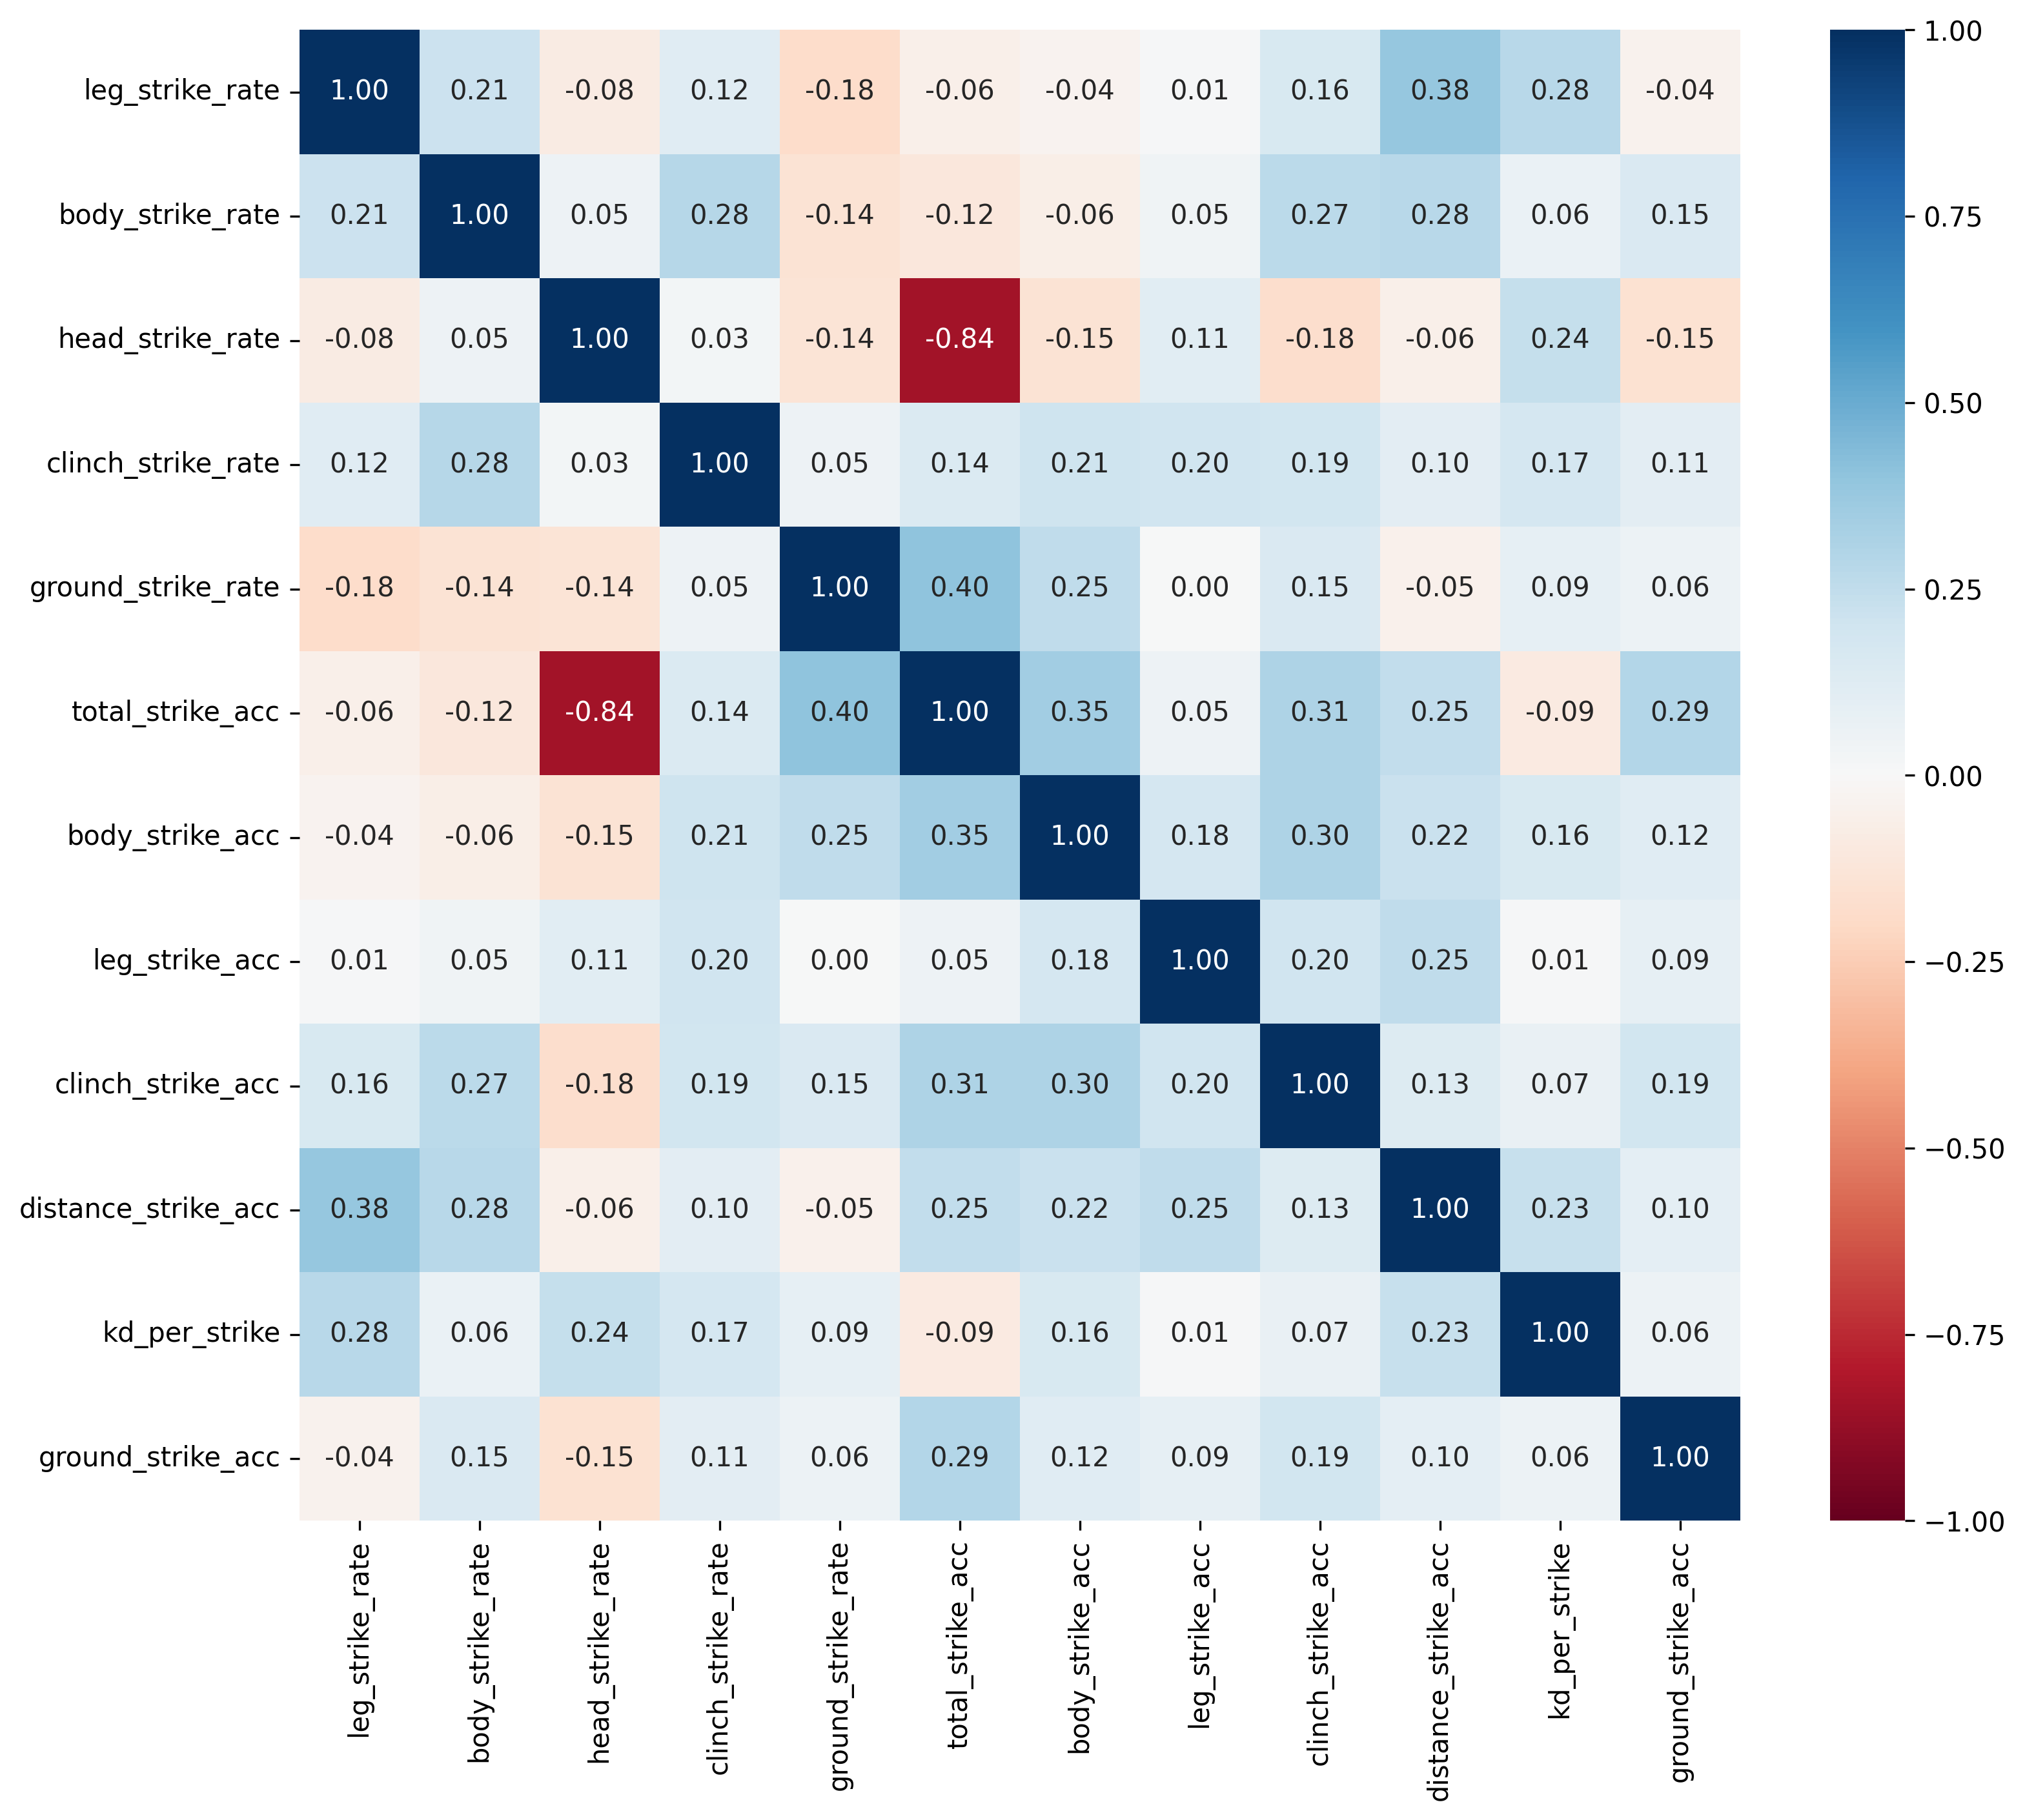

In [451]:
potentially_correlated = cluster_striking_rates + cluster_striking_success
heatmap(perfighter_reduced, potentially_correlated)

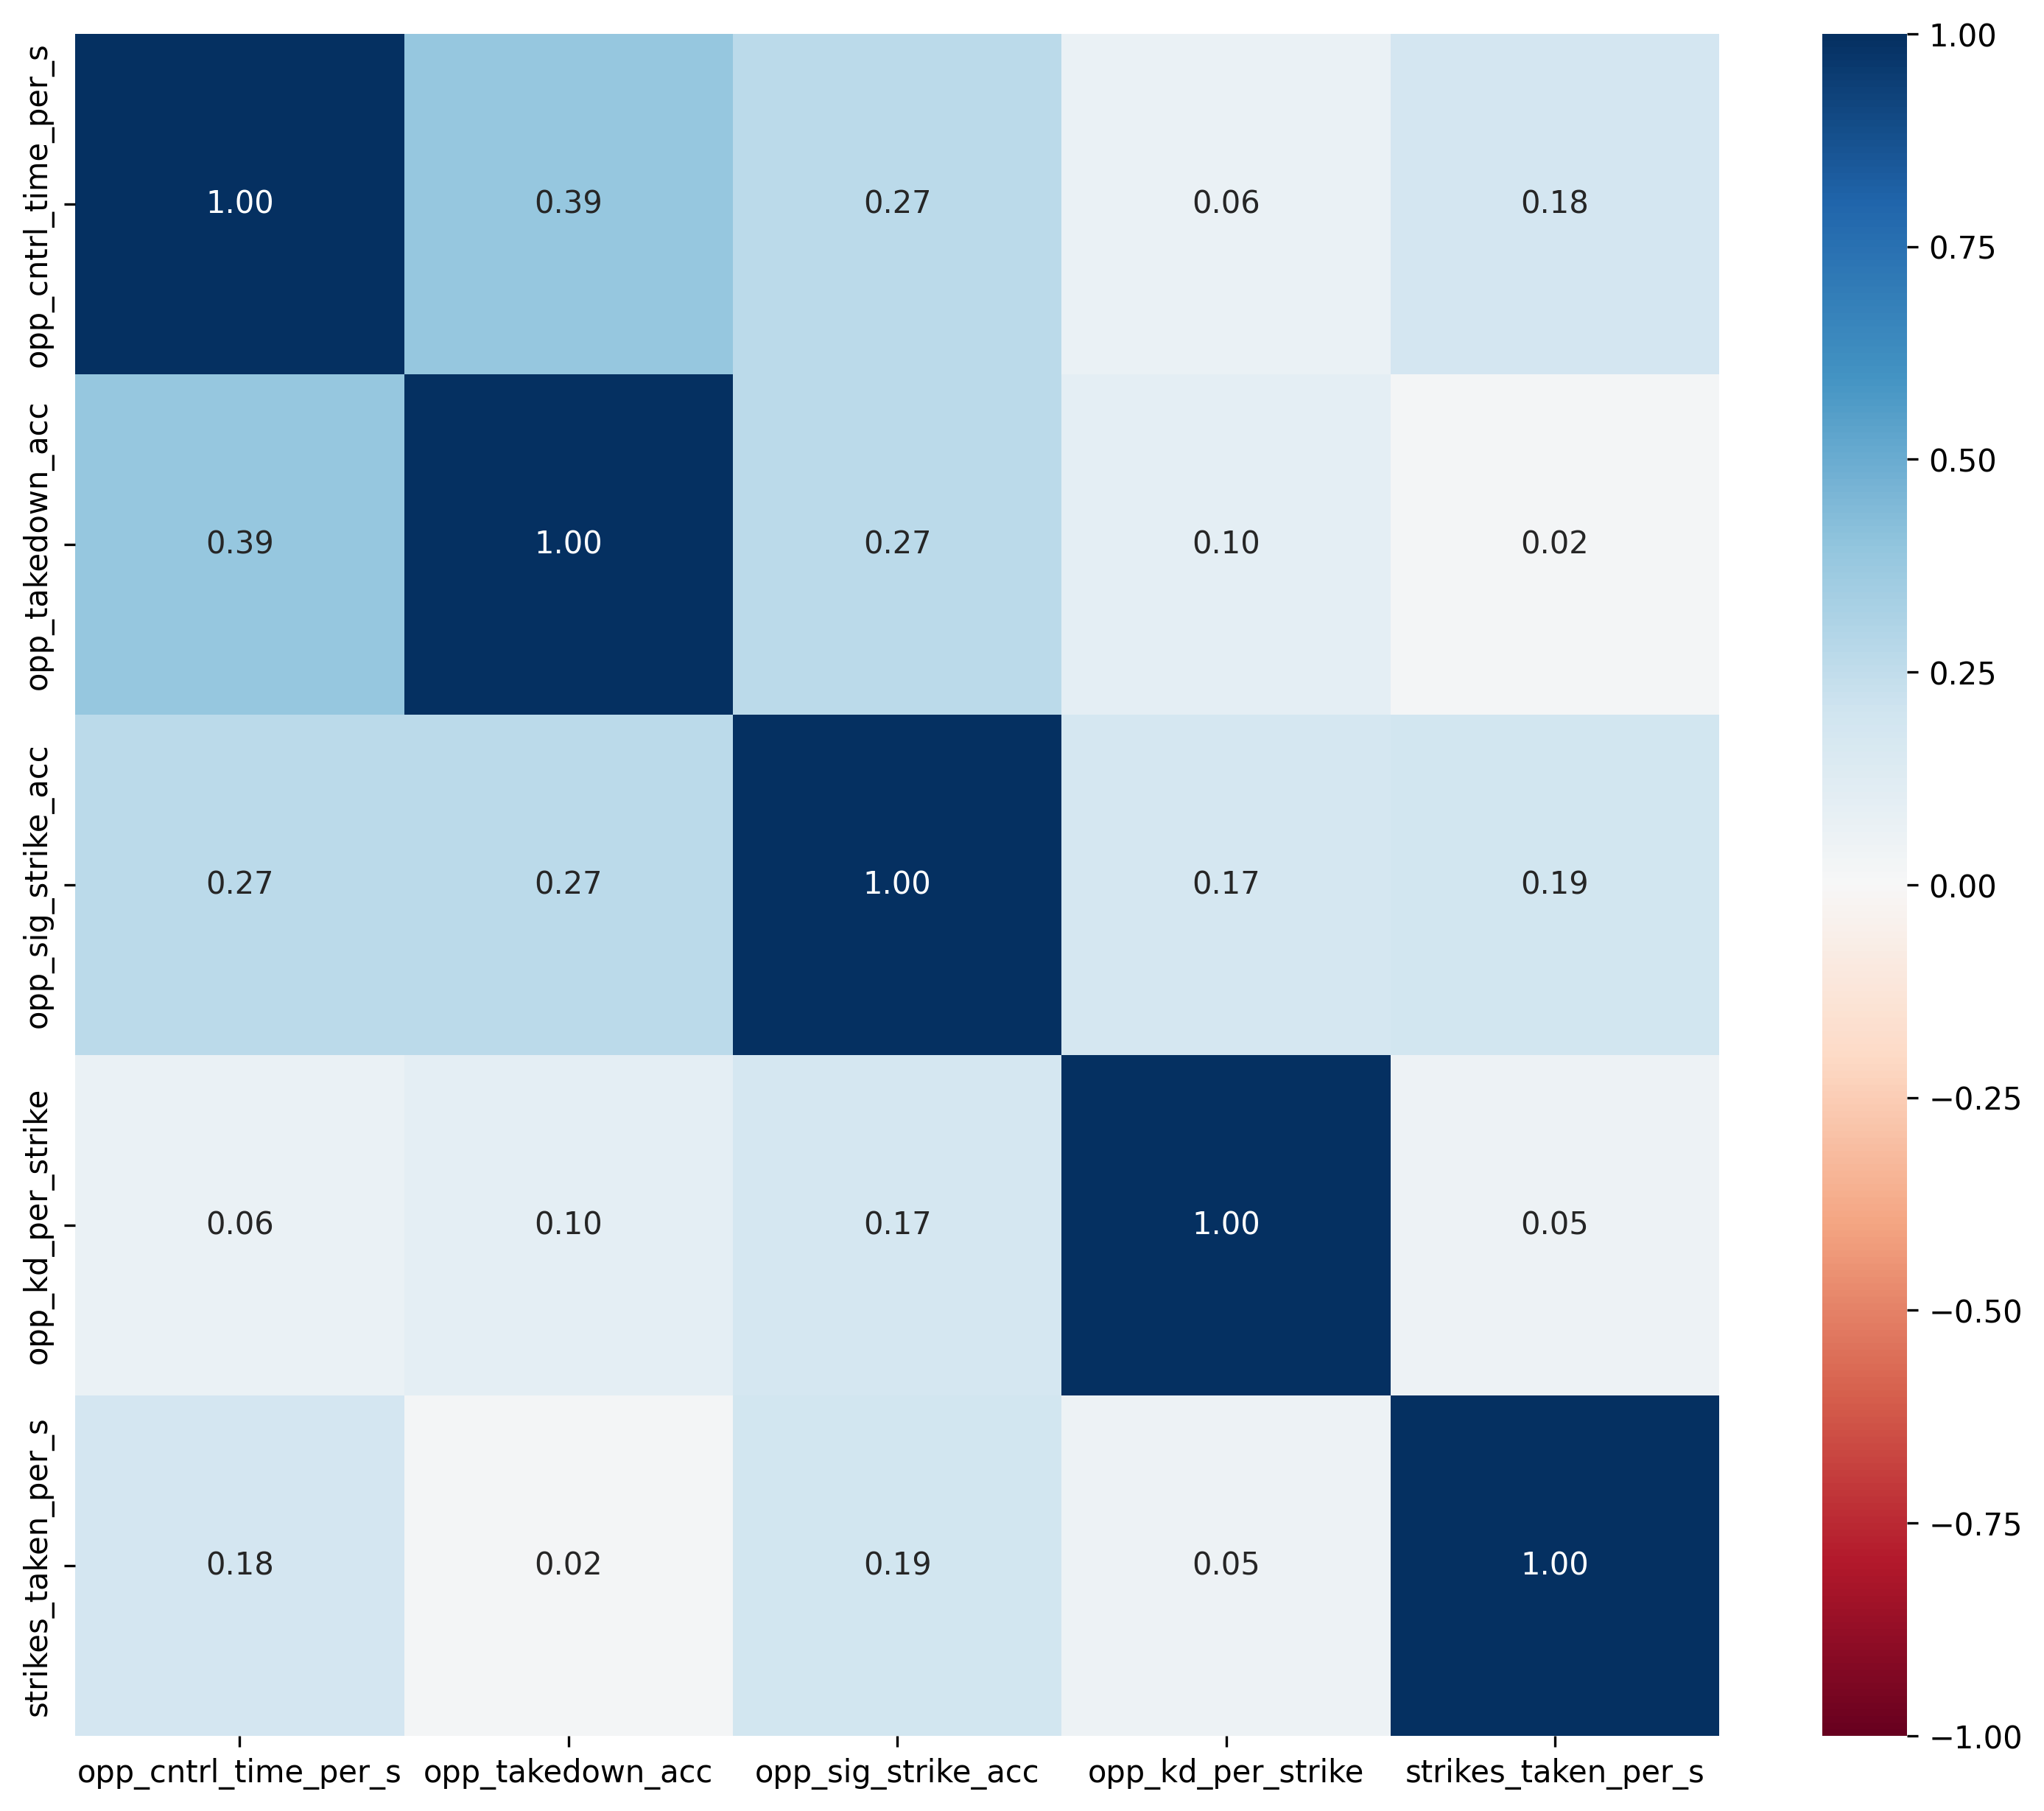

In [452]:
potentially_correlated = cluster_grappling_wrestling_defense + cluster_opp_striking_success
heatmap(perfighter_reduced, potentially_correlated)

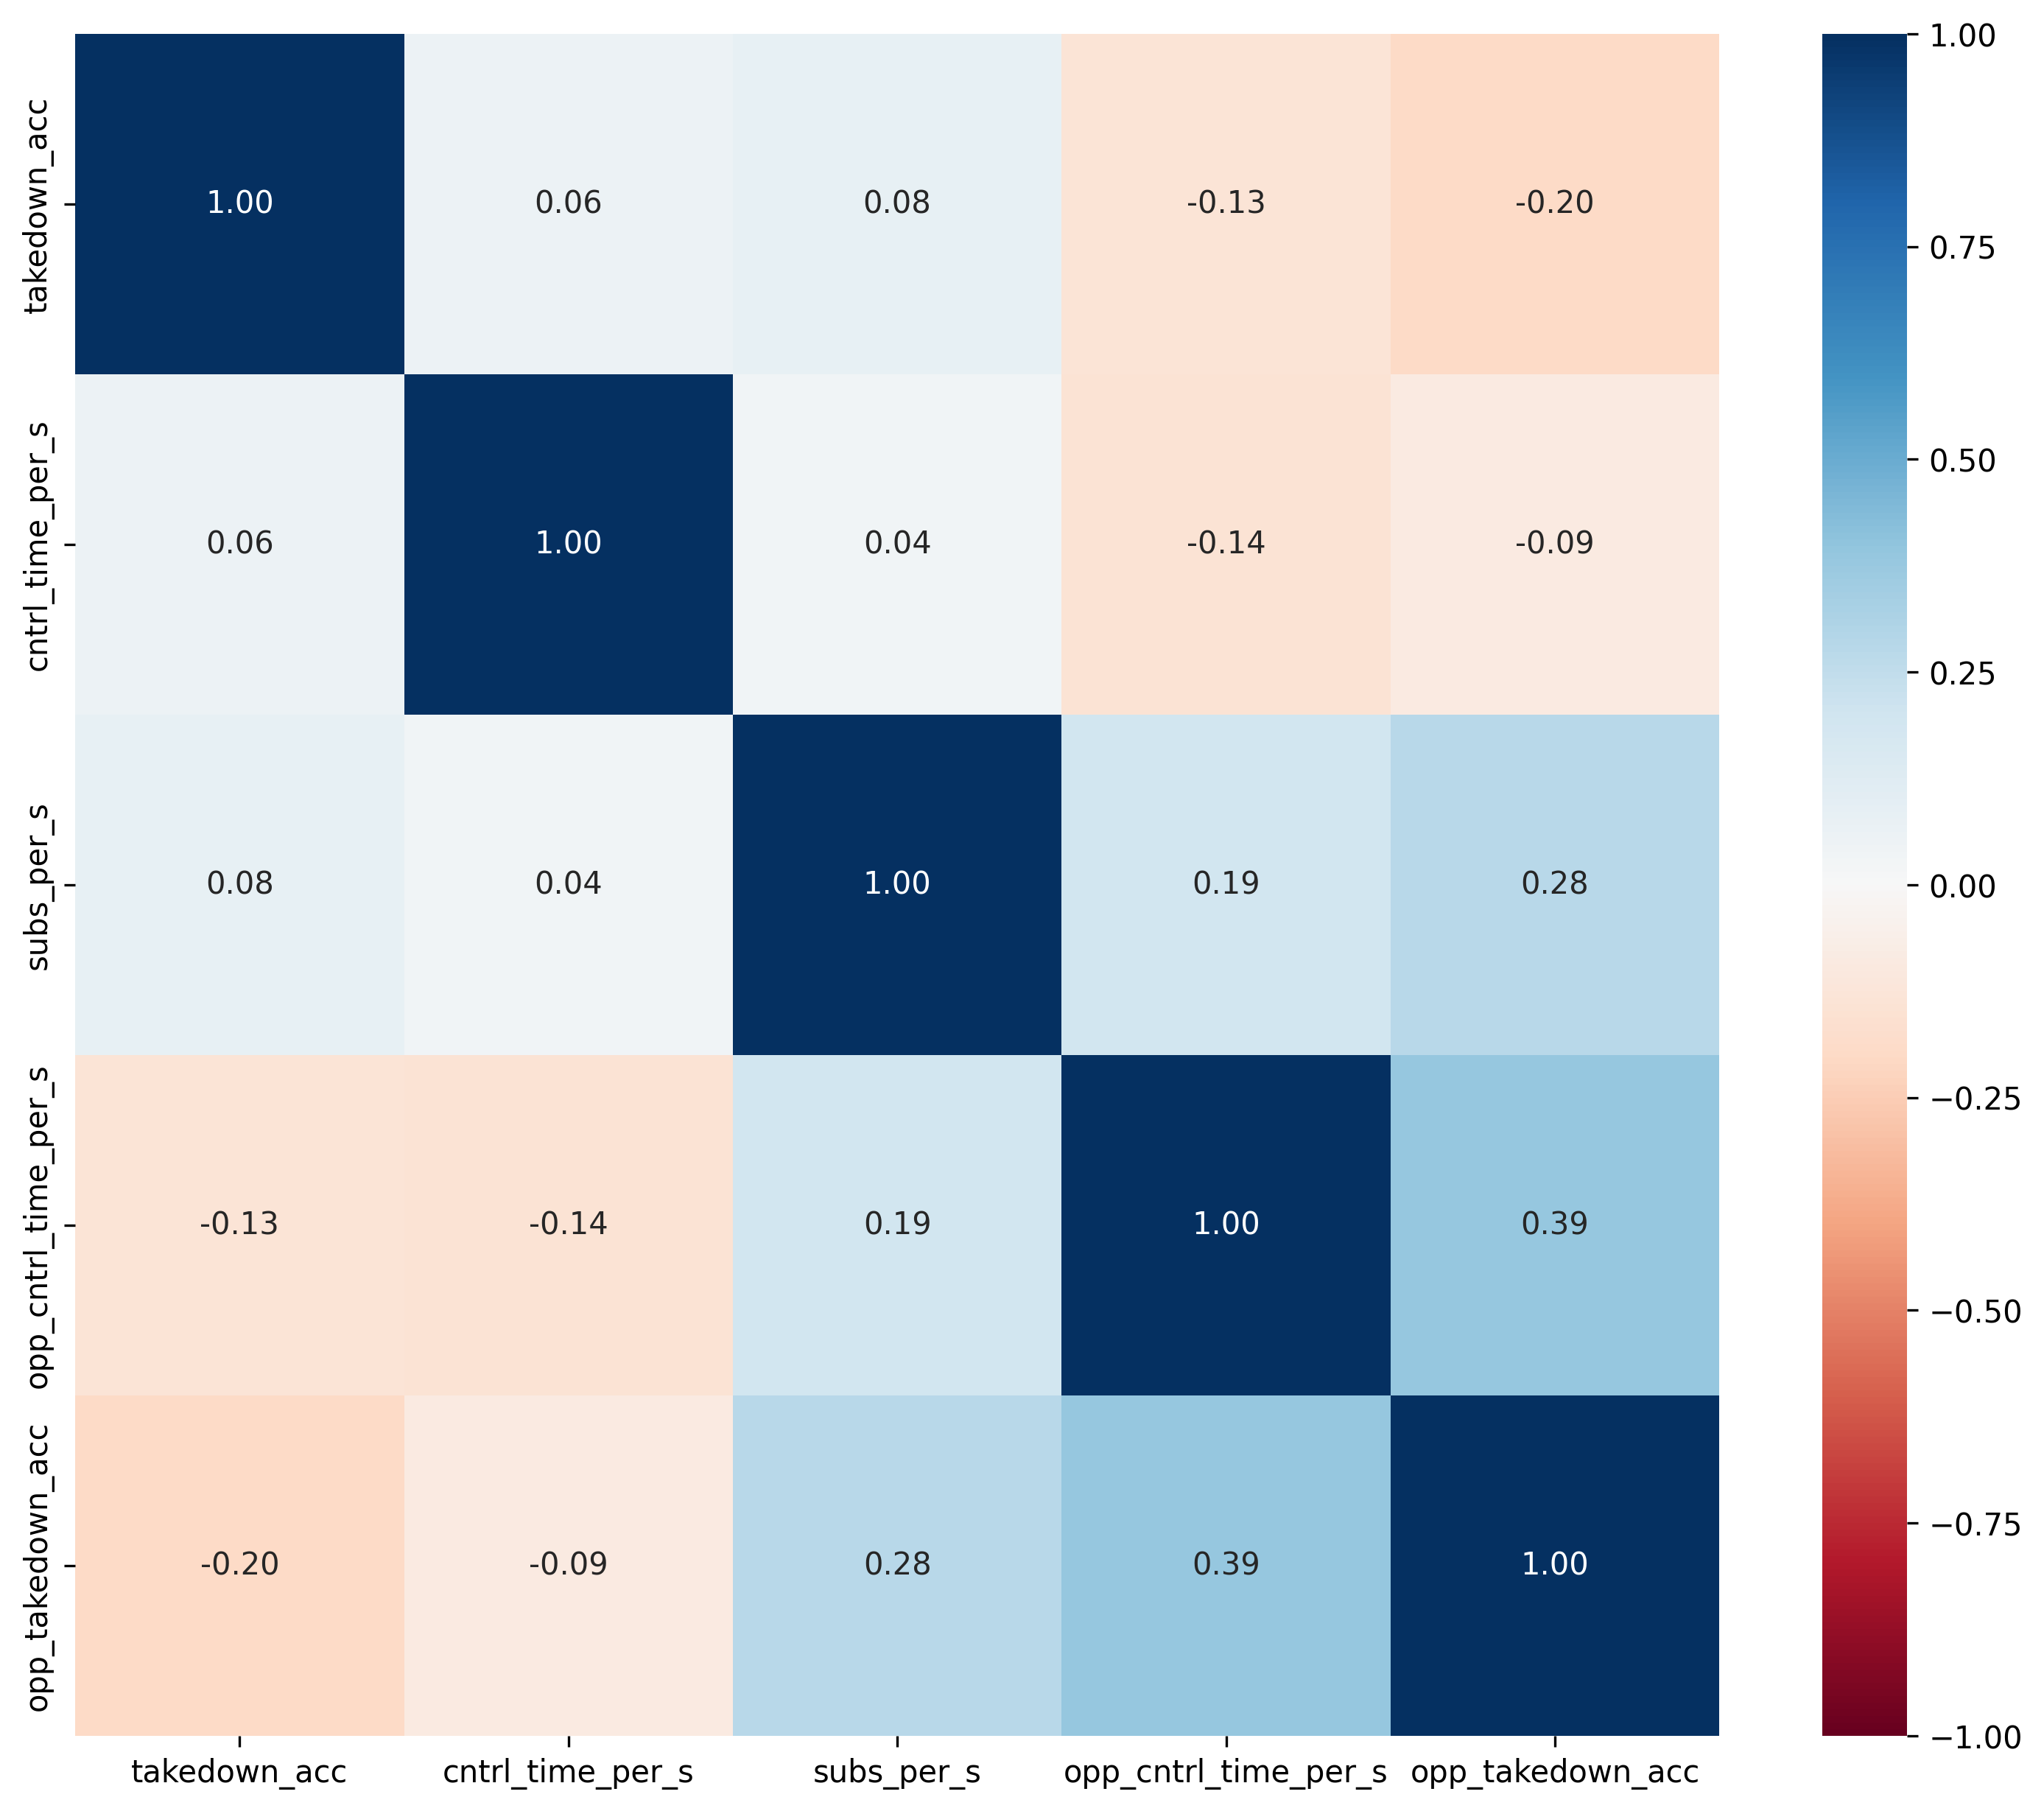

In [453]:
potentially_correlated = cluster_grappling_wrestling_offense + cluster_grappling_wrestling_defense
heatmap(perfighter_reduced, potentially_correlated)

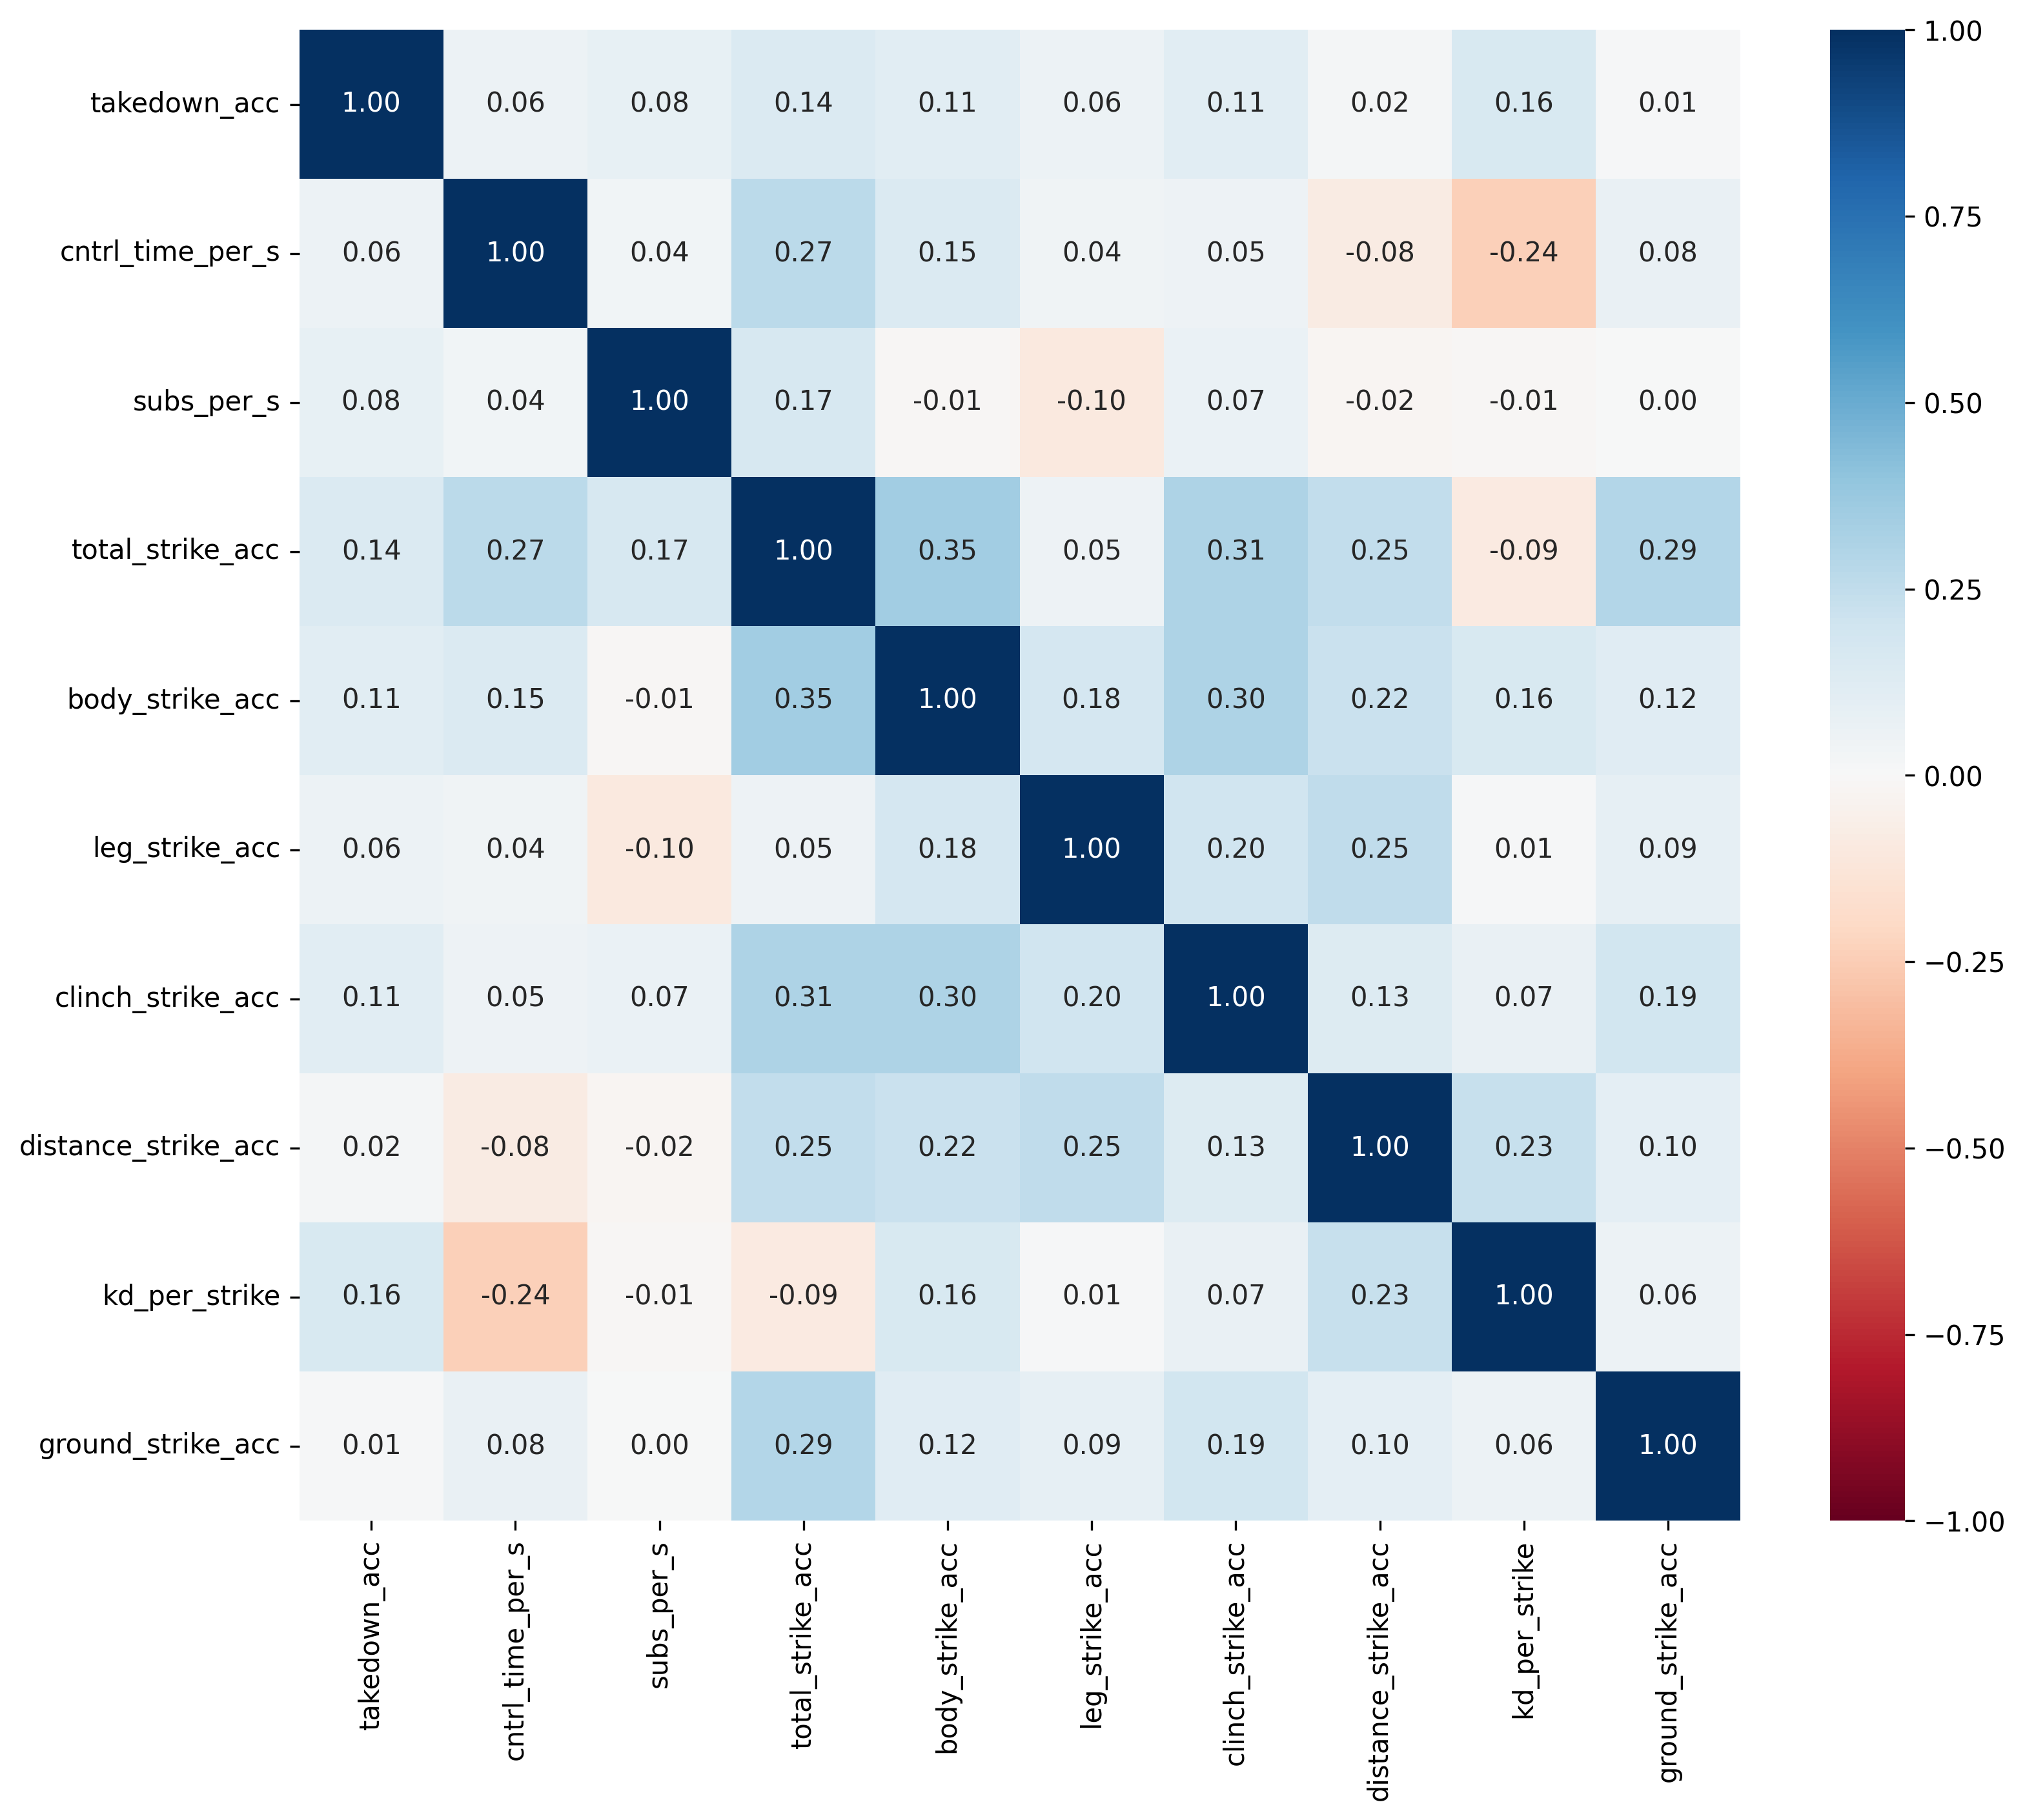

In [454]:
potentially_correlated = cluster_grappling_wrestling_offense + cluster_striking_success
heatmap(perfighter_reduced, potentially_correlated)

In [455]:
print_highly_correlated(perfighter_reduced, potentially_correlated)

There are no highly correlated features with correlation above 0.5


In [456]:
subset = list(perfighter_reduced.columns)

In [457]:
# subset is to be used in PCA
collinear = ['fights','kd_per_head_strike','distance_strike_per_s','kd_per_s','head_strike_acc','leg_strike_per_s','body_strike_per_s','distance_strike_rate','clinch_strike_per_s','ground_strike_per_s','sig_strike_acc','head_strike_per_s','opp_distance_strike_acc','opp_kd_per_head_strike','opp_kd_per_s','opp_takedowns_per_s','takedowns_attempted_per_s','takedowns_per_s']
for col in collinear:
    subset.remove(col)

In [458]:
# scale the data for kmeans clustering
kmeans_data = perfighter_reduced[subset].copy()

In [459]:
scaler = StandardScaler()
kmeans_data_scaled = scaler.fit_transform(kmeans_data)
# here, in practice we may write this scaler to a pickle so that can apply to future fighters

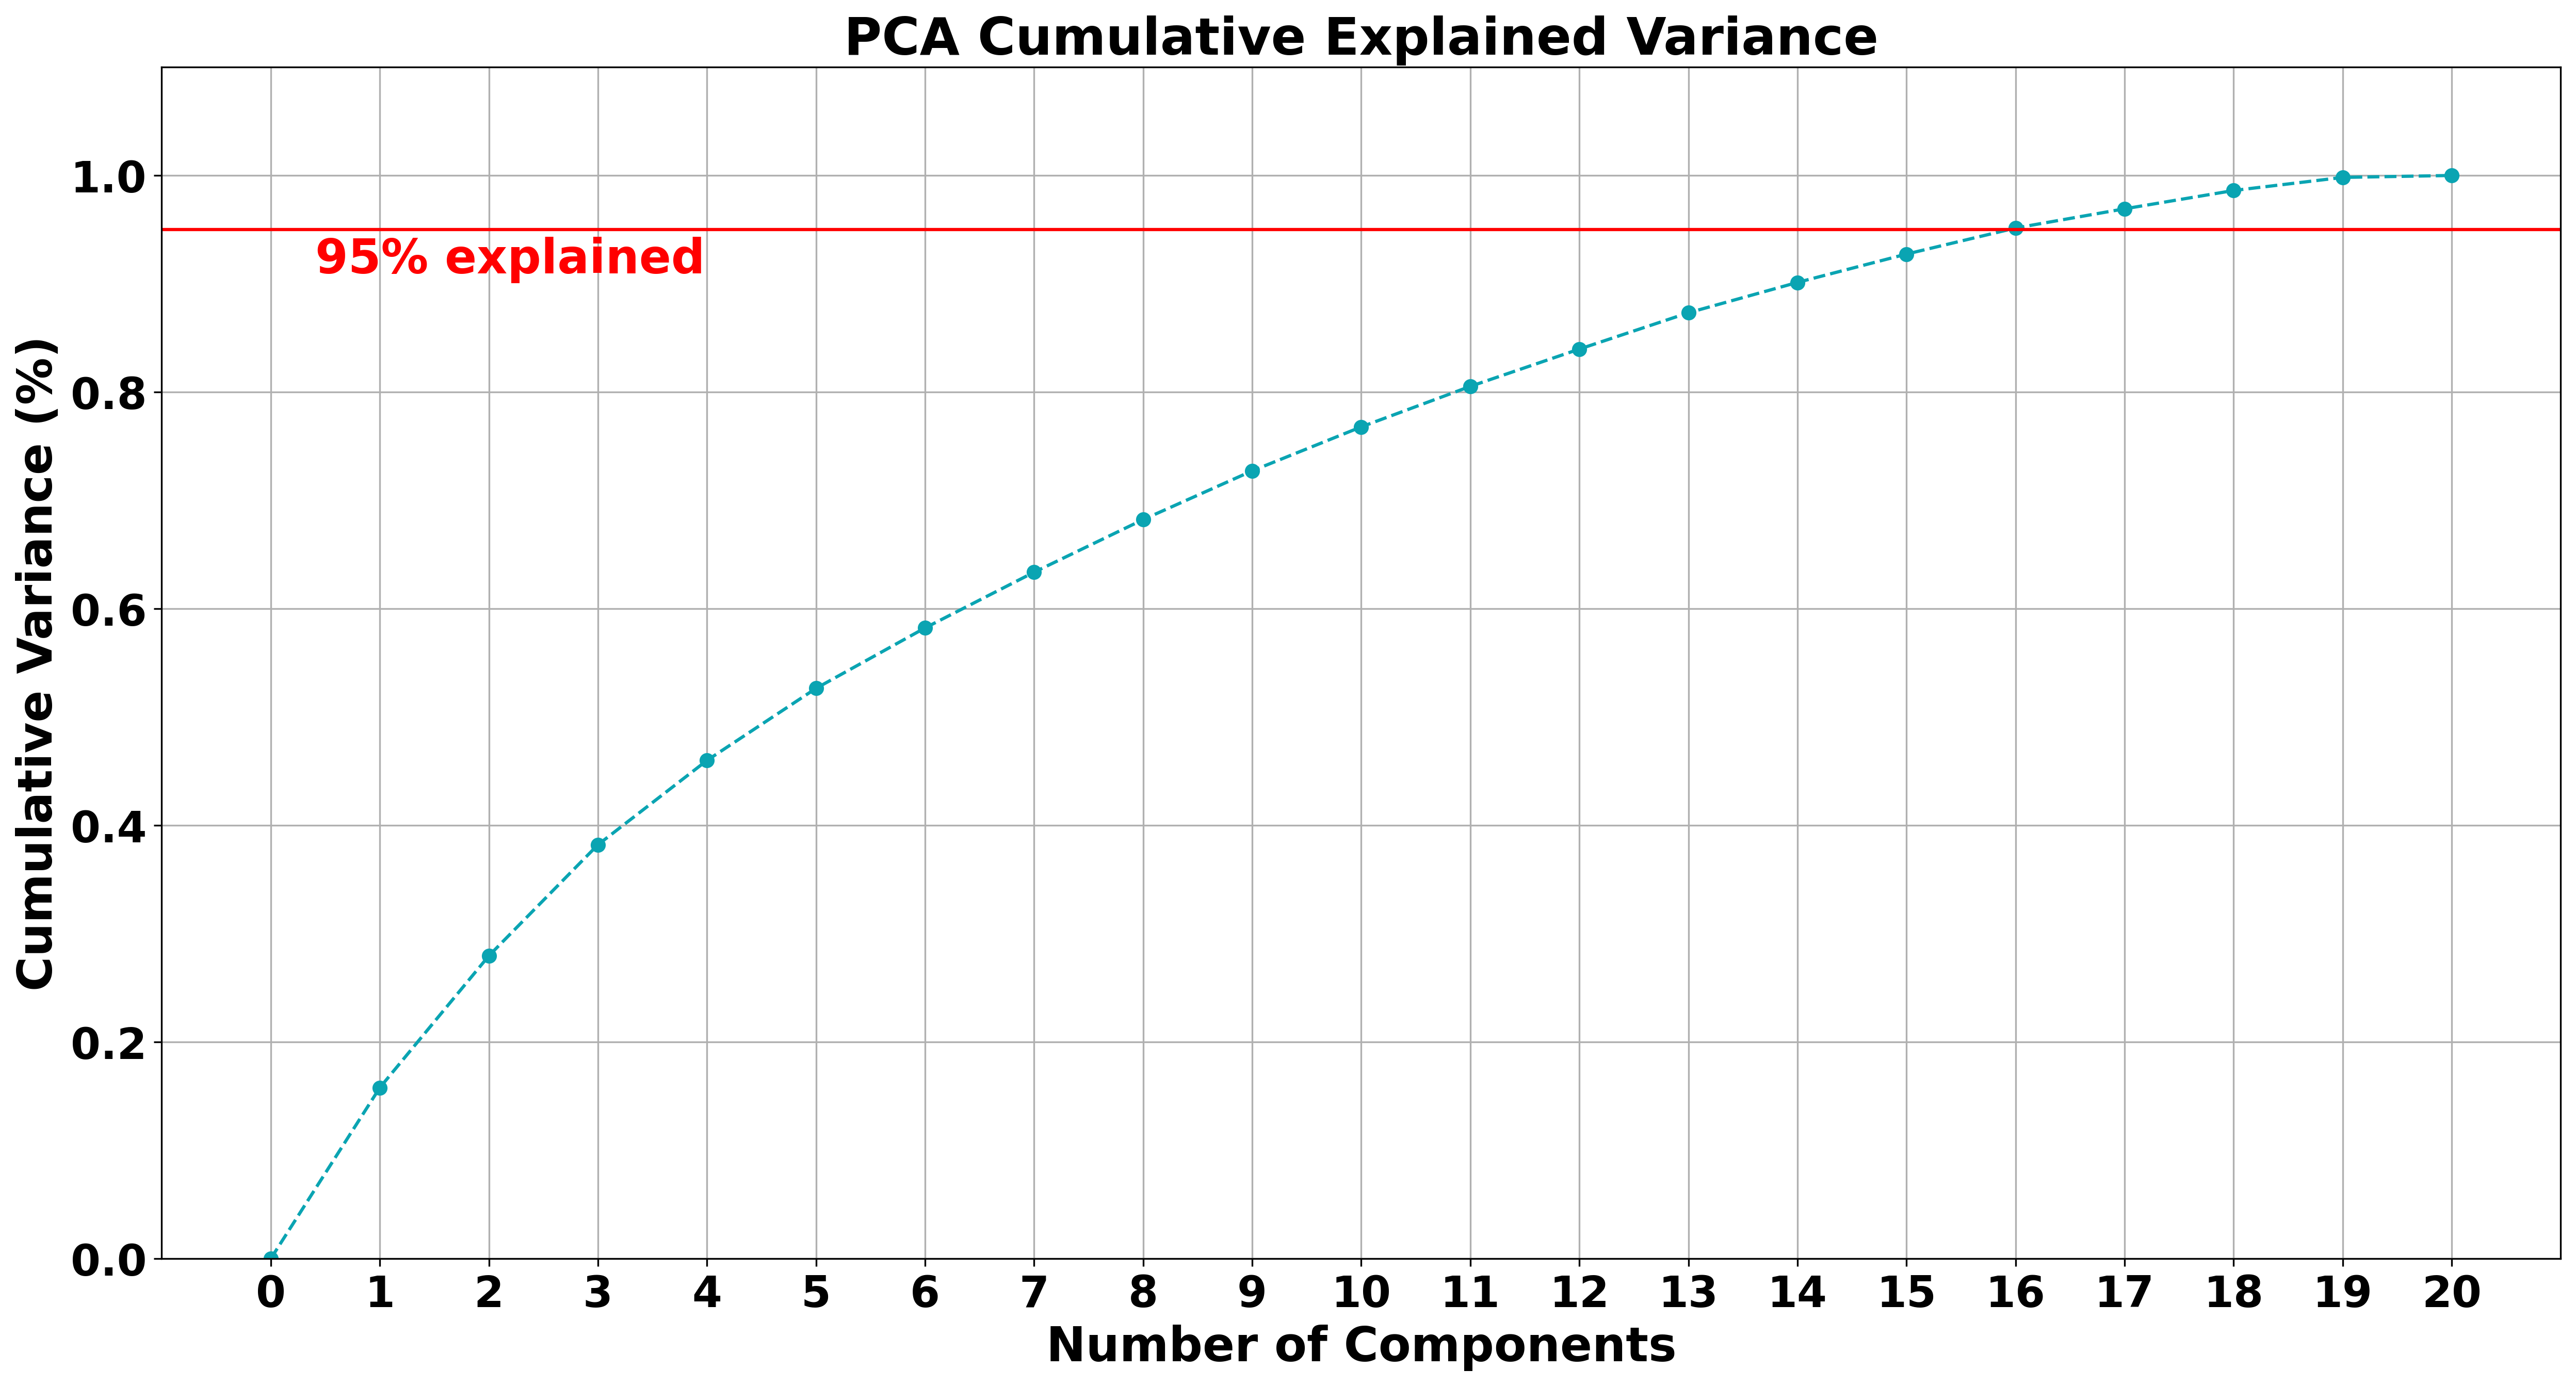

In [460]:
rs = 42 # set the random variable for similar relults across all of the pca fits

# Determine number of PCA components
pca = PCA(len(subset), random_state=rs).fit(kmeans_data_scaled) # include number of features for test

# Plot PCA components and cumulative explained variance
fig, ax = plt.subplots(figsize=(20, 10))
x = np.arange(0, len(subset) + 1, step=1)
y = np.cumsum(np.insert(pca.explained_variance_ratio_, 0, 0))

plt.ylim(0.0,1.1)
plt.plot(x, y, marker='o', linestyle='--', color='#0AA4B2')

plt.xlabel('Number of Components', fontsize=22, color='black', fontweight='bold')
plt.xticks(np.arange(0, len(subset) + 1, step=1), fontsize=20, color='black', fontweight='bold') #change from 0-based array index to 1-based human-readable label
plt.ylabel('Cumulative Variance (%)', fontsize=22, color='black', fontweight='bold')
plt.yticks(fontsize=20, color='black', fontweight='bold')
plt.title('PCA Cumulative Explained Variance', fontsize=24, fontweight='bold')

plt.axhline(y=0.95, color='r', linestyle='-')
plt.text(0.41, 0.91, '95% explained', color = 'red', fontsize=22, fontweight='bold')

ax.grid(axis='x')
ax.grid(axis='y')
#fig.savefig('pca_variance.png')
plt.show()

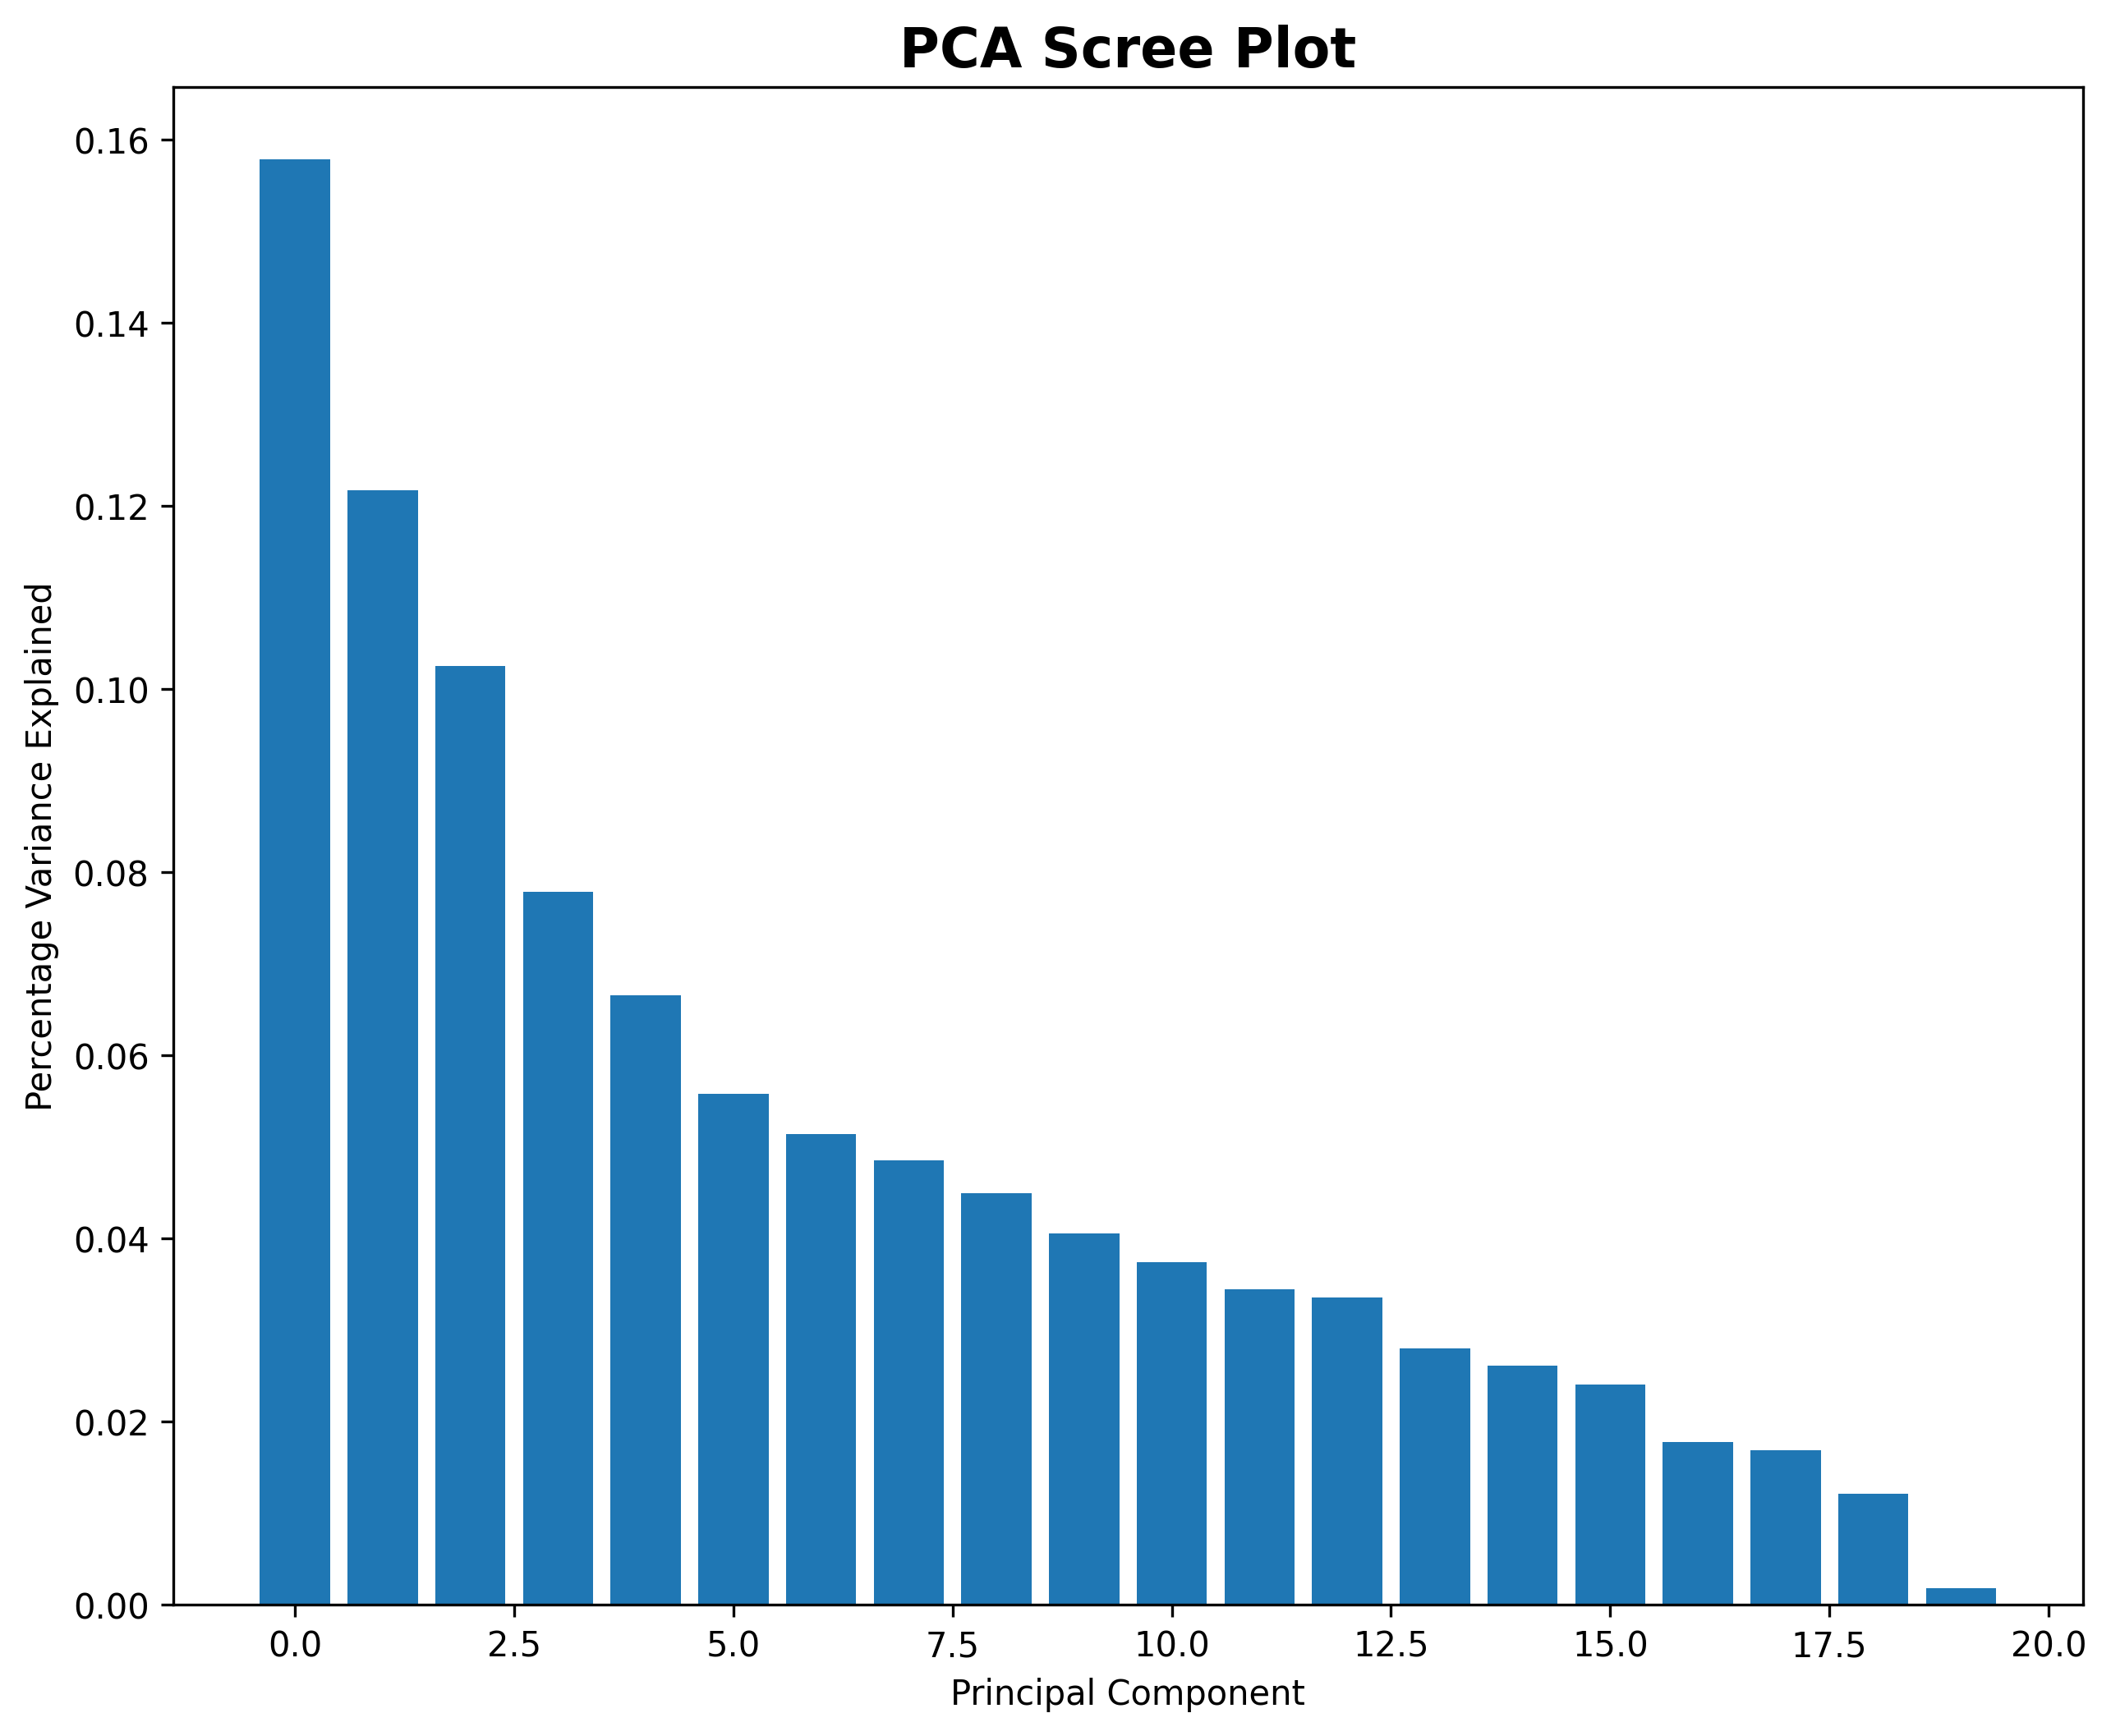

In [461]:
# Display Scree plot
fig, ax = plt.subplots(figsize=(10,8))
x = np.arange(0, len(subset), step=1)
y = pca.explained_variance_ratio_

plt.bar(x, y)
plt.title('PCA Scree Plot', fontsize=16, fontweight='bold')
plt.xlabel('Principal Component')
plt.ylabel('Percentage Variance Explained')
plt.show()

In [464]:
# Rebuild PCA witth chosen number of components
pca = PCA(16, random_state=rs)

# Transform the clustering data
cluster_data_pca = pca.fit_transform(kmeans_data_scaled)

# future, can store the a pickle of the pca fit for future clustering 

Clusters =  2 :  Silhouette Score =  0.10514101889170546
Clusters =  3 :  Silhouette Score =  0.10123428303977092
Clusters =  4 :  Silhouette Score =  0.06501893447732973
Clusters =  5 :  Silhouette Score =  0.08166168948432663
Clusters =  6 :  Silhouette Score =  0.07371322045231704
Clusters =  7 :  Silhouette Score =  0.07766602311716995
Clusters =  8 :  Silhouette Score =  0.07521712842977038
Clusters =  9 :  Silhouette Score =  0.05968963844754757
Clusters =  10 :  Silhouette Score =  0.05907085488609732
Clusters =  11 :  Silhouette Score =  0.0714726469090965
Clusters =  12 :  Silhouette Score =  0.06463773752753514
Clusters =  13 :  Silhouette Score =  0.062033636045200805
Clusters =  14 :  Silhouette Score =  0.06614198927214021
Clusters =  15 :  Silhouette Score =  0.061647340693876757
Clusters =  16 :  Silhouette Score =  0.059869974778422624
Clusters =  17 :  Silhouette Score =  0.05608304200481019
Clusters =  18 :  Silhouette Score =  0.05317577430934975
Clusters =  19 :  Si

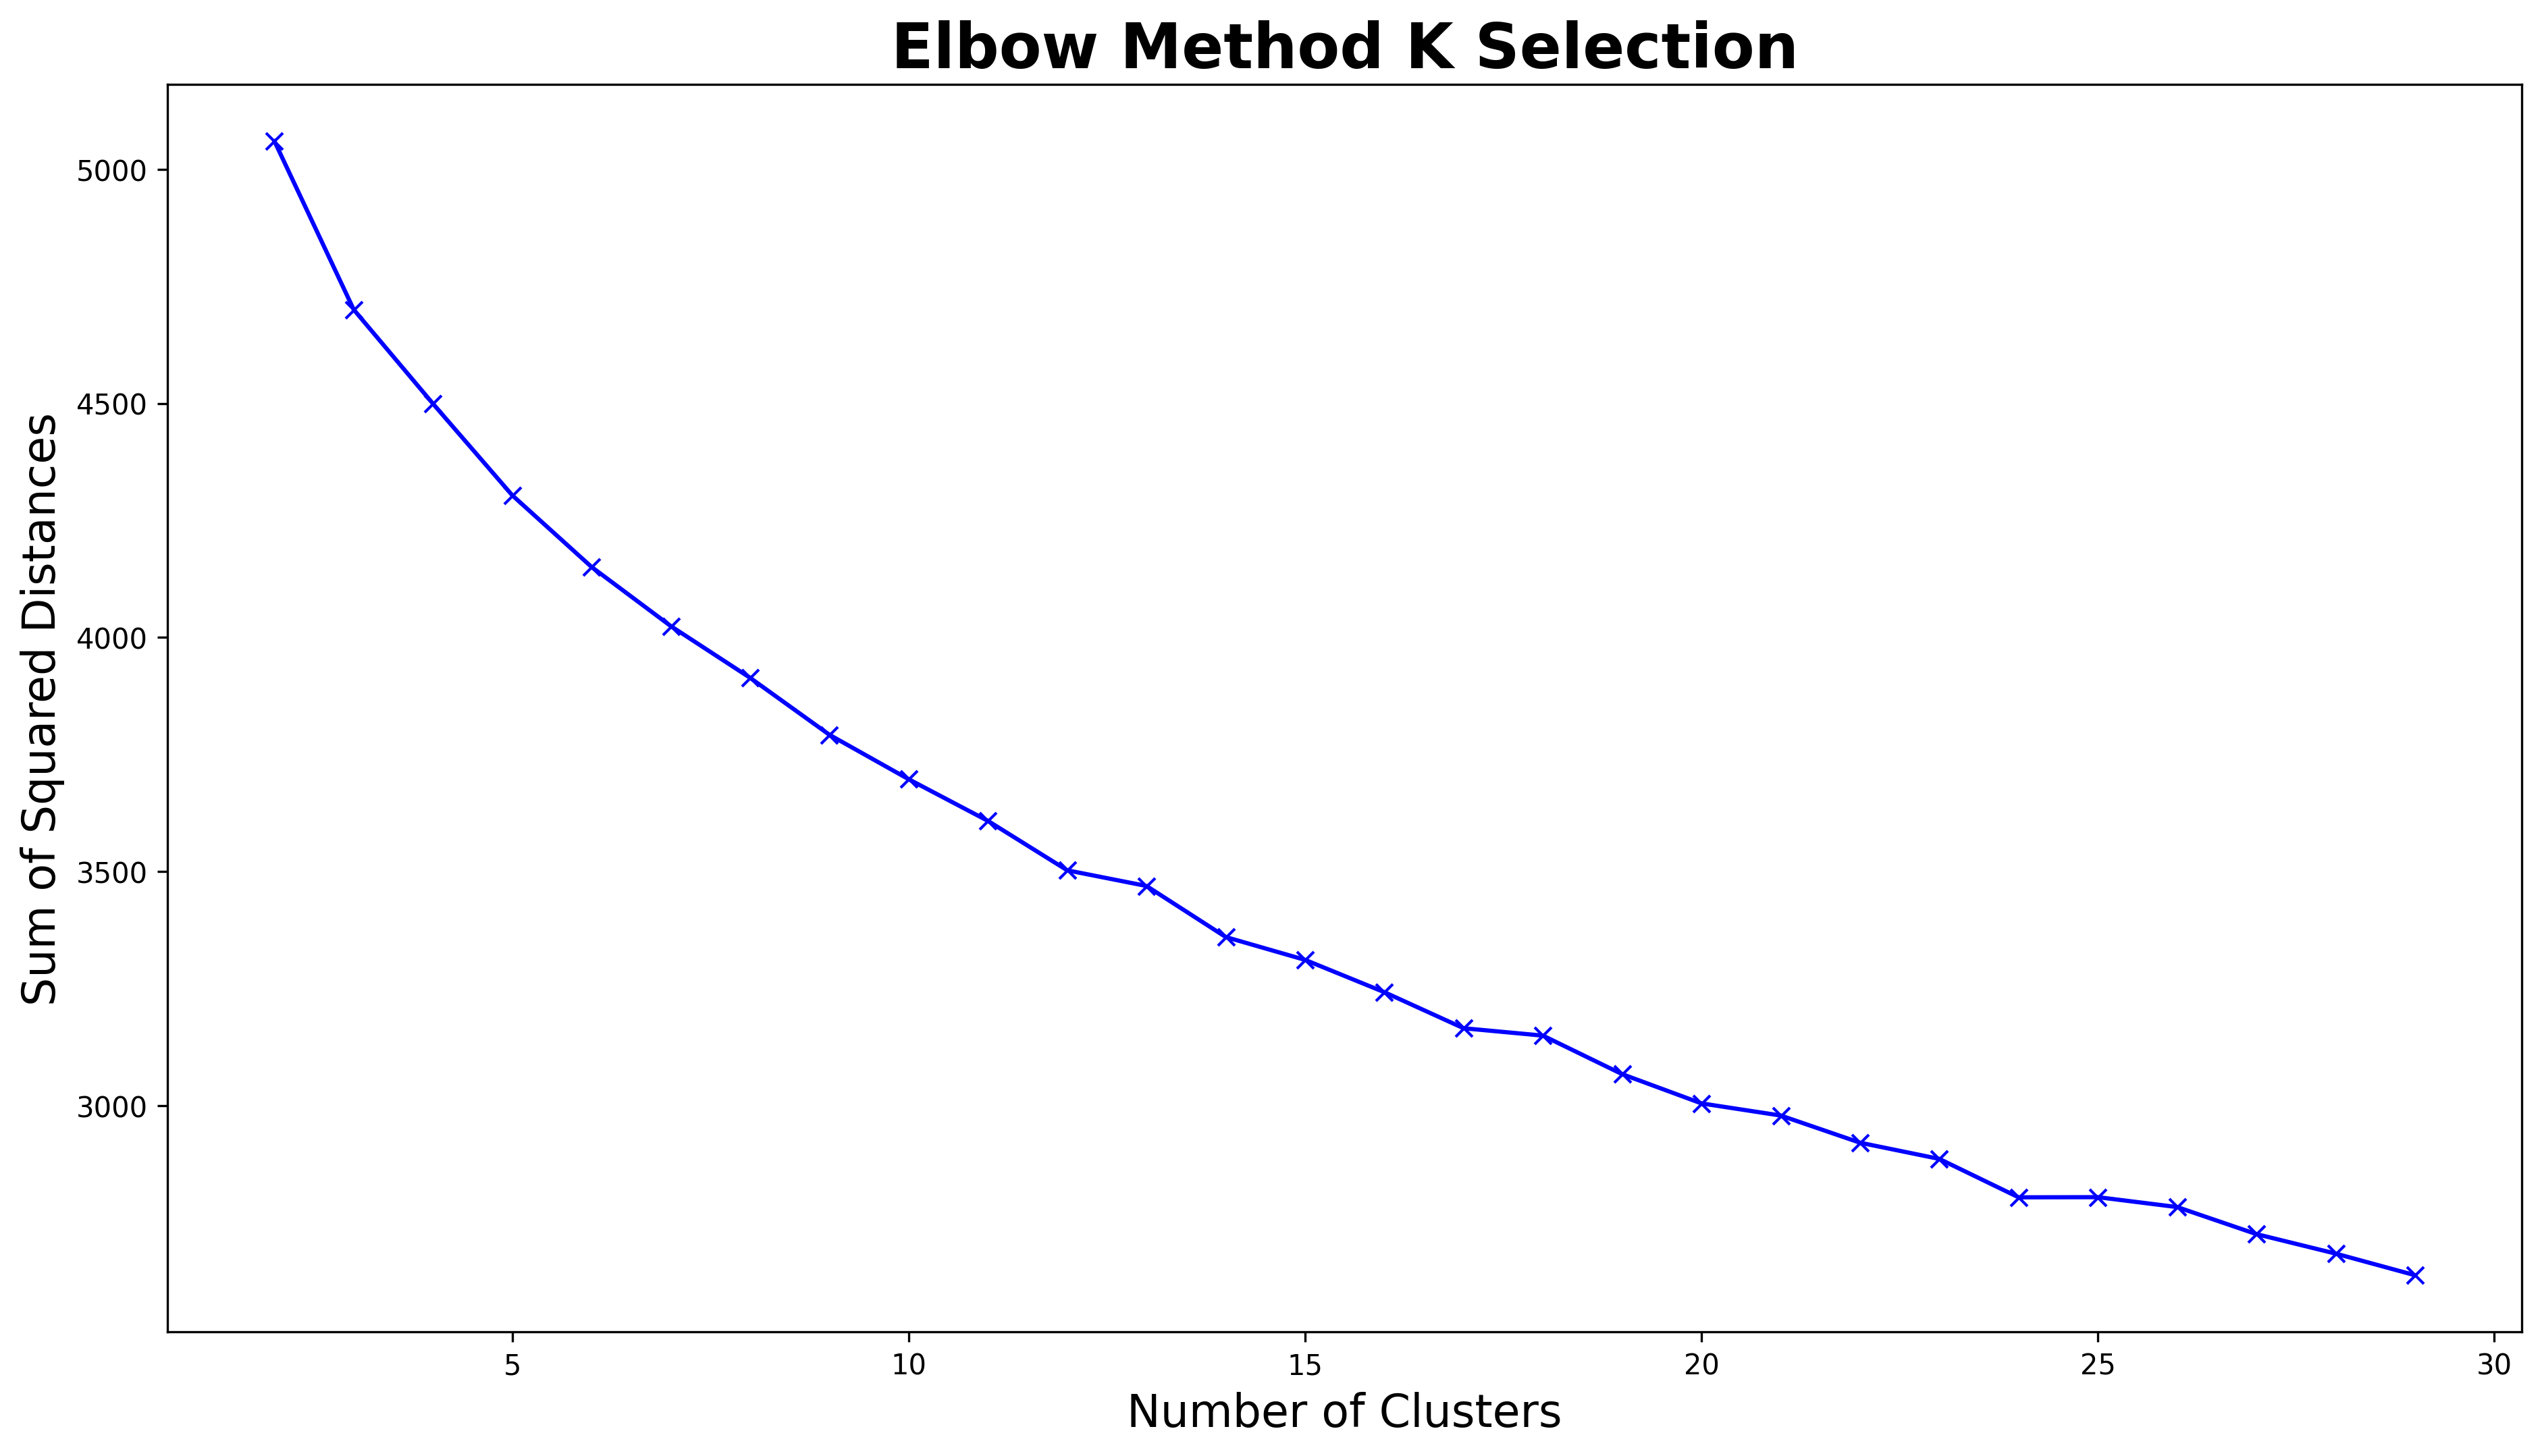

In [465]:
sum_of_squared_distances = []
for i in range(2,30):
    km = KMeans(n_clusters=i, random_state=rs)
    prediction = km.fit_predict(cluster_data_pca)
    
    silhouette = silhouette_score(cluster_data_pca, prediction, random_state=rs)
    print ('Clusters = ', i, ':  Silhouette Score = ', silhouette)
    
    sum_of_squared_distances.append(km.inertia_)

fig = plt.figure(figsize=(15, 8))
plt.plot(range(2,30), sum_of_squared_distances, 'bx-')
plt.xlabel('Number of Clusters', fontsize=16)
plt.ylabel('Sum of Squared Distances', fontsize=16)
plt.title('Elbow Method K Selection', fontsize=22, fontweight='bold')
plt.show()

In [466]:
# create the Kmeans model with correct num cluster - seems like 12 
km = KMeans(n_clusters=12, random_state=rs)
y_predicted = km.fit_predict(cluster_data_pca)

In [467]:
y_predicted.size

299

In [468]:
kmeans_data['cluster'] = y_predicted

In [469]:
kmeans_data.groupby('cluster').mean().sort_values(by = "opp_takedown_acc")

,head_strike_rate,leg_strike_rate,ground_strike_rate,body_strike_rate,clinch_strike_rate,kd_per_strike,leg_strike_acc,ground_strike_acc,body_strike_acc,clinch_strike_acc,total_strike_acc,distance_strike_acc,takedown_acc,cntrl_time_per_s,subs_per_s,opp_cntrl_time_per_s,opp_takedown_acc,opp_sig_strike_acc,opp_kd_per_strike,strikes_taken_per_s
cluster,,,,,,,,,,,,,,,,,,,,
8,0.691322,0.063315,0.101905,0.082500,0.097861,0.005640,0.813094,0.585731,0.705030,0.627310,0.472357,0.327649,0.651211,0.196180,0.000717,0.178944,0.264924,0.355830,0.002390,0.037429
4,0.614178,0.151870,0.173750,0.067794,0.100273,0.014024,0.774927,0.685400,0.849052,0.697328,0.578545,0.420233,0.525015,0.125746,0.001639,0.229921,0.356768,0.453885,0.002971,0.044502
0,0.550750,0.045301,0.161966,0.063237,0.080187,0.001774,0.814798,0.627451,0.738229,0.628755,0.582695,0.309267,0.465751,0.388699,0.001152,0.173718,0.357840,0.376851,0.001939,0.035510
5,0.507306,0.085462,0.099984,0.116195,0.159131,0.003219,0.875031,0.744315,0.836685,0.763553,0.654957,0.431539,0.451777,0.246597,0.000672,0.313032,0.390459,0.435665,0.001936,0.038845
2,0.717661,0.045142,0.064494,0.068487,0.058087,0.002044,0.805511,0.653131,0.659078,0.597955,0.445588,0.304669,0.335661,0.169330,0.000905,0.193393,0.395088,0.412892,0.002554,0.065833
1,0.591536,0.094403,0.064029,0.109954,0.108923,0.002444,0.768698,0.611804,0.685489,0.687702,0.523412,0.354576,0.338214,0.192344,0.000900,0.279710,0.424980,0.429942,0.001873,0.051233
9,0.452076,0.049206,0.250525,0.067277,0.092137,0.001652,0.876621,0.673216,0.846240,0.740560,0.713186,0.351105,0.513112,0.460511,0.001580,0.209073,0.441348,0.488299,0.005370,0.028266
10,0.645040,0.073889,0.072360,0.064572,0.096107,0.003474,0.836175,0.462259,0.774368,0.602546,0.502398,0.347088,0.333013,0.171294,0.000560,0.236378,0.459484,0.440828,0.011719,0.050316
3,0.540943,0.010841,0.203900,0.039592,0.052479,0.003062,0.238804,0.597736,0.763394,0.503977,0.594811,0.254314,0.514136,0.404808,0.001108,0.146268,0.482444,0.433868,0.004549,0.031415


In [470]:
# What do these clusters mean?

# 2,8,10 head strikers
# 9,3,4 ground and pound
# 5,11,1 clinch strikes
# 4,1,5 leg strikes
# 4,8,11 heavy hitters
# 6,4,8 takedowns
# 9,3,0 control time goats
# 10,9,3 get knocked down a lot
# 7,11,4 sub a lot
# 5,1,8 body strikers
# 6,9,5 strike accuracy
# 7,11,6 good takedown defense

# 10 - haymakers (lots of sig head strikes but get knocked down a lot)
# 0 - methodical (controlling opponent most of their fights)
# 5 - muay thai (excel lead, body, clinch strikes)
# 3 - haymakers with no wrestling ability - get taken down more often
# 6 - most accurate strikers overall, uses their striking to open up wrestling takedowns
# 9 - most control time - good wrestling ability but costs them knockdowns
# 7 - top jiu jitsu fighters, sub a lot, good takedown defense
# 1 - most aimless punches, spray and pray
# 2 - head hunters, look for mostly head strikes
# 4 - take advantage of leg strikes to get late ko's
# 8 - Wrestlers. defensive fighters that are patient and look for openings
# 11 - jiu jitsu fighters with more of an ability to leave the fight standing. good rounded fighter

In [564]:
win_perc = intermediate_analysis_df[['fighter','opponent','result']]

In [565]:
win_perc = win_perc.merge(kmeans_data.reset_index()[['fighter','cluster']],on='fighter')
win_perc = win_perc.merge(kmeans_data.reset_index()[['fighter','cluster']],left_on='opponent',right_on='fighter')

In [566]:
winners = win_perc[win_perc.result == 0].rename(columns={'fighter_x':'loser','opponent':'winner','cluster_x':'losing_cluster','cluster_y':'winning_cluster'})

In [567]:
losers = win_perc[win_perc.result == 1].rename(columns={'fighter_x':'winner','opponent':'loser','cluster_x':'winning_cluster','cluster_y':'losing_cluster'})

In [568]:
style_dynamics = pd.concat([winners,losers])[['loser','winner','losing_cluster','winning_cluster']]

In [569]:
winners = style_dynamics.groupby(['winning_cluster', 'losing_cluster']).size().unstack(fill_value=0)

In [570]:
losers = style_dynamics.groupby(['losing_cluster', 'winning_cluster']).size().unstack(fill_value=0)

In [571]:
win_percentage = winners / (winners + losers)

In [572]:
# more data will make this look better - try that first with full csv on desktop
# could either not remove fighters with less than 5 fights or
# use the kmeans to predict the cluster for fighters who have less than 5 fights
win_percentage.style.background_gradient()

losing_cluster,0,1,2,3,4,5,6,7,8,9,10,11
winning_cluster,,,,,,,,,,,,
0,0.500000,0.701493,0.536585,0.500000,0.357143,0.500000,0.800000,0.642857,0.358491,0.607143,0.750000,0.766667
1,0.298507,0.500000,0.600000,0.500000,0.500000,0.400000,nan,0.533333,0.354839,0.615385,0.700000,0.636364
2,0.463415,0.400000,0.500000,0.250000,0.333333,0.200000,0.000000,0.200000,0.366667,0.200000,0.500000,0.400000
3,0.500000,0.500000,0.750000,nan,0.250000,0.666667,0.250000,0.333333,0.250000,0.166667,0.666667,0.666667
4,0.642857,0.500000,0.666667,0.750000,0.500000,0.428571,0.750000,0.600000,0.473684,0.500000,0.777778,0.750000
5,0.500000,0.600000,0.800000,0.333333,0.571429,0.500000,nan,0.571429,0.388889,0.500000,0.625000,0.588235
6,0.200000,nan,1.000000,0.750000,0.250000,nan,0.500000,0.700000,0.000000,0.000000,1.000000,0.000000
7,0.357143,0.466667,0.800000,0.666667,0.400000,0.428571,0.300000,0.500000,0.296296,0.333333,1.000000,0.500000
8,0.641509,0.645161,0.633333,0.750000,0.526316,0.611111,1.000000,0.703704,0.500000,0.583333,0.636364,0.692308


In [573]:
# clusters were defined using fighters that had more than 5 fights. Apply kmeans predictor to generate what cluster the fighters
# with less than 5 fights fall in
kmeans_data_2 = perfighter[subset].copy()

# use predict and transform instead of fit predict and fit transform
kmeans_data_scaled_2 = scaler.transform(kmeans_data_2)
cluster_data_pca_2 = pca.transform(kmeans_data_scaled_2)
y_predicted_2 = km.predict(cluster_data_pca_2)

kmeans_data_2['cluster'] = y_predicted_2

In [574]:
win_perc = intermediate_analysis_df[['fighter','opponent','result']]
win_perc = win_perc.merge(kmeans_data_2.reset_index()[['fighter','cluster']],on='fighter')
win_perc = win_perc.merge(kmeans_data_2.reset_index()[['fighter','cluster']],left_on='opponent',right_on='fighter')
winners = win_perc[win_perc.result == 0].rename(columns={'fighter_x':'loser','opponent':'winner','cluster_x':'losing_cluster','cluster_y':'winning_cluster'})
losers = win_perc[win_perc.result == 1].rename(columns={'fighter_x':'winner','opponent':'loser','cluster_x':'winning_cluster','cluster_y':'losing_cluster'})
style_dynamics = pd.concat([winners,losers])[['loser','winner','losing_cluster','winning_cluster']]
winners = style_dynamics.groupby(['winning_cluster', 'losing_cluster']).size().unstack(fill_value=0)
losers = style_dynamics.groupby(['losing_cluster', 'winning_cluster']).size().unstack(fill_value=0)
win_percentage = winners / (winners + losers)
win_percentage.style.background_gradient()

losing_cluster,0,1,2,3,4,5,6,7,8,9,10,11
winning_cluster,,,,,,,,,,,,
0,0.500000,0.710843,0.671642,0.615385,0.500000,0.591837,0.800000,0.795455,0.406250,0.700000,0.785714,0.836735
1,0.289157,0.500000,0.625000,0.500000,0.461538,0.416667,0.000000,0.548387,0.320000,0.360000,0.722222,0.622222
2,0.328358,0.375000,0.500000,0.500000,0.388889,0.242424,0.000000,0.520000,0.269841,0.315789,0.631579,0.320000
3,0.384615,0.500000,0.500000,0.500000,0.250000,0.266667,0.250000,0.517241,0.266667,0.153846,0.583333,0.526316
4,0.500000,0.538462,0.611111,0.750000,0.500000,0.363636,0.625000,0.705882,0.476190,0.481481,0.870968,0.750000
5,0.408163,0.583333,0.757576,0.733333,0.636364,0.500000,0.166667,0.454545,0.360000,0.444444,0.827586,0.666667
6,0.200000,1.000000,1.000000,0.750000,0.375000,0.833333,0.500000,0.842105,0.000000,0.125000,1.000000,0.000000
7,0.204545,0.451613,0.480000,0.482759,0.294118,0.545455,0.157895,0.500000,0.266667,0.212121,1.000000,0.458333
8,0.593750,0.680000,0.730159,0.733333,0.523810,0.640000,1.000000,0.733333,0.500000,0.607143,0.833333,0.708333


In [485]:
kmeans_data_2 = kmeans_data_2.reset_index()

In [489]:
intermediate_analysis_df = intermediate_analysis_df.merge(kmeans_data_2[['fighter','cluster']],how = 'left',on = 'fighter')
intermediate_analysis_df = intermediate_analysis_df.merge(kmeans_data_2.rename(columns = {'fighter':'opponent','cluster':'opponent_cluster'})[['opponent','opponent_cluster']],how = 'left',on = 'opponent')

In [490]:
intermediate_analysis_df

,fight_url,date,fighter,opponent,result,division,stance,method,age,reach,...,opponent_prefight_ave_sig_strikes_def,opponent_prefight_ave_total_strikes_def,opponent_prefight_ave_head_strikes_def,opponent_prefight_ave_body_strikes_def,opponent_prefight_ave_leg_strikes_def,opponent_prefight_ave_distance_strikes_def,opponent_prefight_ave_clinch_strikes_def,opponent_prefight_ave_ground_strikes_def,cluster,opponent_cluster
0,http://ufcstats.com/fight-details/00835554f95f...,1994-03-11,royce gracie,patrick smith,1,Open Weight,Southpaw,KO/TKO,55.000000,73.276261,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6,4
1,http://ufcstats.com/fight-details/17ee4caf0698...,1994-03-11,remco pardoel,alberta cerra leon,1,Open Weight,Southpaw,SUB,42.954038,73.276261,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6,7
2,http://ufcstats.com/fight-details/3b020d4914b4...,1994-03-11,orlando wiet,robert lucarelli,1,Open Weight,Southpaw,KO/TKO,42.954038,73.276261,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,7,7
3,http://ufcstats.com/fight-details/4acab67848e7...,1994-03-11,scott morris,sean daugherty,1,Open Weight,Orthodox,SUB,42.954038,73.276261,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,11,7
4,http://ufcstats.com/fight-details/4b9ae533ccb3...,1994-03-11,patrick smith,ray wizard,1,Open Weight,Orthodox,SUB,58.000000,73.276261,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2038,http://ufcstats.com/fight-details/1c0bf66167c9...,2012-06-23,milton vieira,felipe arantes,0,Featherweight,Orthodox,DRAW,43.000000,73.276261,...,66.754651,51.944628,76.195259,29.166667,35.000000,73.035714,16.666667,45.238095,7,8
2039,http://ufcstats.com/fight-details/93ffadd9e41a...,2012-07-21,francisco rivera,roland delorme,0,Bantamweight,Orthodox,DRAW,40.000000,70.000000,...,42.782678,37.916667,51.899510,6.250000,0.000000,56.862745,9.375000,0.000000,1,11
2040,http://ufcstats.com/fight-details/ccacbe6a4c31...,2012-07-21,matthew riddle,chris clements,0,Welterweight,Southpaw,DRAW,36.000000,76.000000,...,39.130435,32.307692,39.534884,33.333333,100.000000,48.571429,100.000000,9.090909,0,5
2041,http://ufcstats.com/fight-details/7e27d9f37c21...,2012-08-04,wagner prado,phil davis,0,Light Heavyweight,Southpaw,DRAW,35.000000,74.000000,...,78.221789,70.018859,85.027776,63.888889,46.666667,80.822445,69.444444,87.037037,2,0


<h2> Fighting up or fighting down

In [611]:
mode_division = intermediate_analysis_df.groupby('fighter')[['fighter','division']].apply(lambda x: x.mode()).reset_index(drop=True)

In [618]:
mode_division[mode_division.fighter == 'wanderlei silva']

,fighter,division
711,wanderlei silva,Catch Weight


In [614]:
ufc_divisions = {  
    "Flyweight": 1,  
    "Bantamweight": 2,  
    "Featherweight": 3,  
    "Lightweight": 4,  
    "Welterweight": 5,  
    "Middleweight": 6,  
    "Light Heavyweight": 7,  
    "Heavyweight": 8,  
    "Catch Weight": 9,  
    "Open Weight": 10,  
    "Super Heavyweight": 11  
}  

{'Bantamweight',
 'Catch Weight',
 'Featherweight',
 'Flyweight',
 'Heavyweight',
 'Light Heavyweight',
 'Lightweight',
 'Middleweight',
 'Open Weight',
 'Super Heavyweight',
 'Welterweight'}

<h1> Machine Learning - classifying the winner

In [ ]:
# label encode the categorical features - cluster, stance

In [32]:
ML_df = intermediate_analysis_df.drop(columns = ['opponent_fight_url','opponent_result','fight_url', 'date', 'fighter', 'opponent', 'division',
       'stance', 'method','opponent_stance','result'])

In [33]:
ML_labels = intermediate_analysis_df['result']

In [34]:
X_train, X_test,y_train, y_test = train_test_split(ML_df, ML_labels,stratify = ML_labels, test_size = 0.20)

In [35]:
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

train accuracy    : 84.29 %
test accuracy : 85.07 %


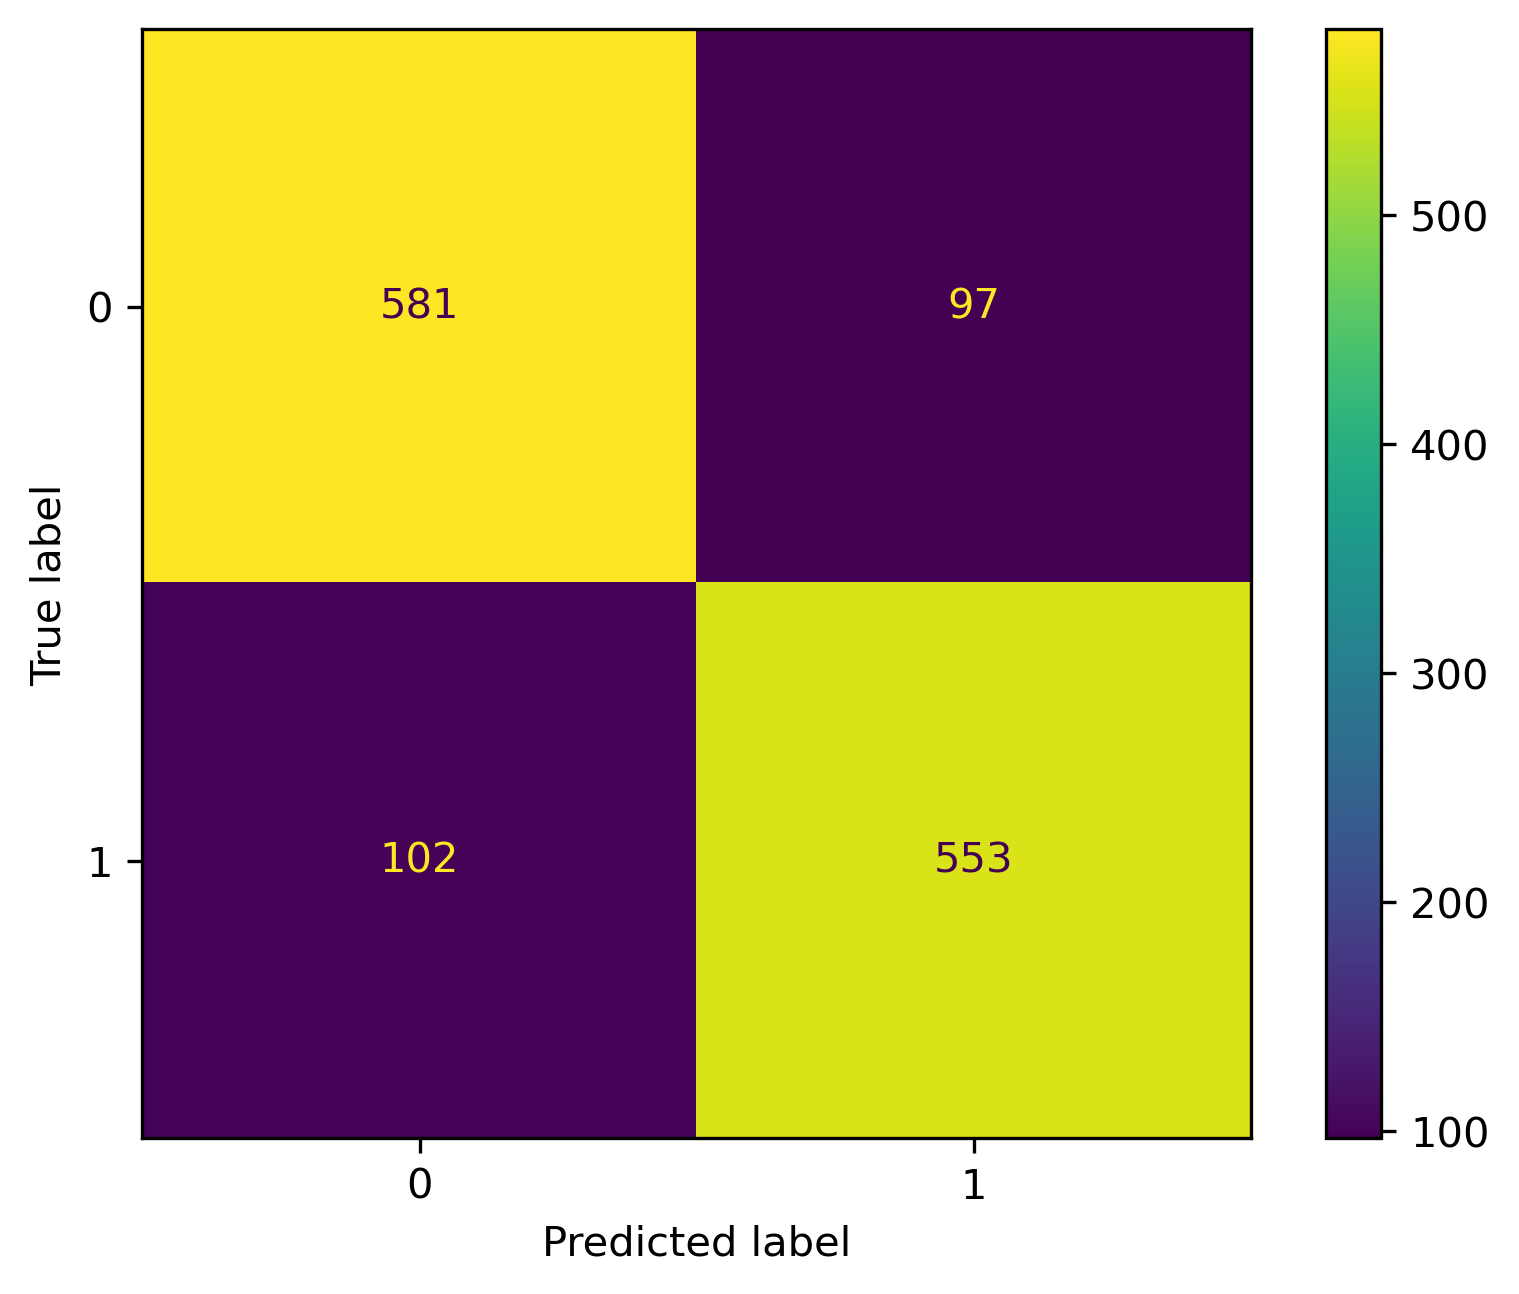

<Figure size 1920x1440 with 0 Axes>

In [41]:
clf = LogisticRegression(solver = 'sag',max_iter = 10000)
# clf = DecisionTreeClassifier(ccp_alpha = 0.001)
clf.fit(X_train, y_train)

predictions = clf.predict(X_test)
train_accuracy = round(clf.score(X_train, y_train) * 100, 2)
test_accuracy = round(accuracy_score(predictions, y_test) * 100, 2)

print("train accuracy    :",train_accuracy ,"%")
print("test accuracy :",test_accuracy ,"%")
cm = confusion_matrix(y_test, predictions, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot()

plt.show()
plt.savefig('temp.png')

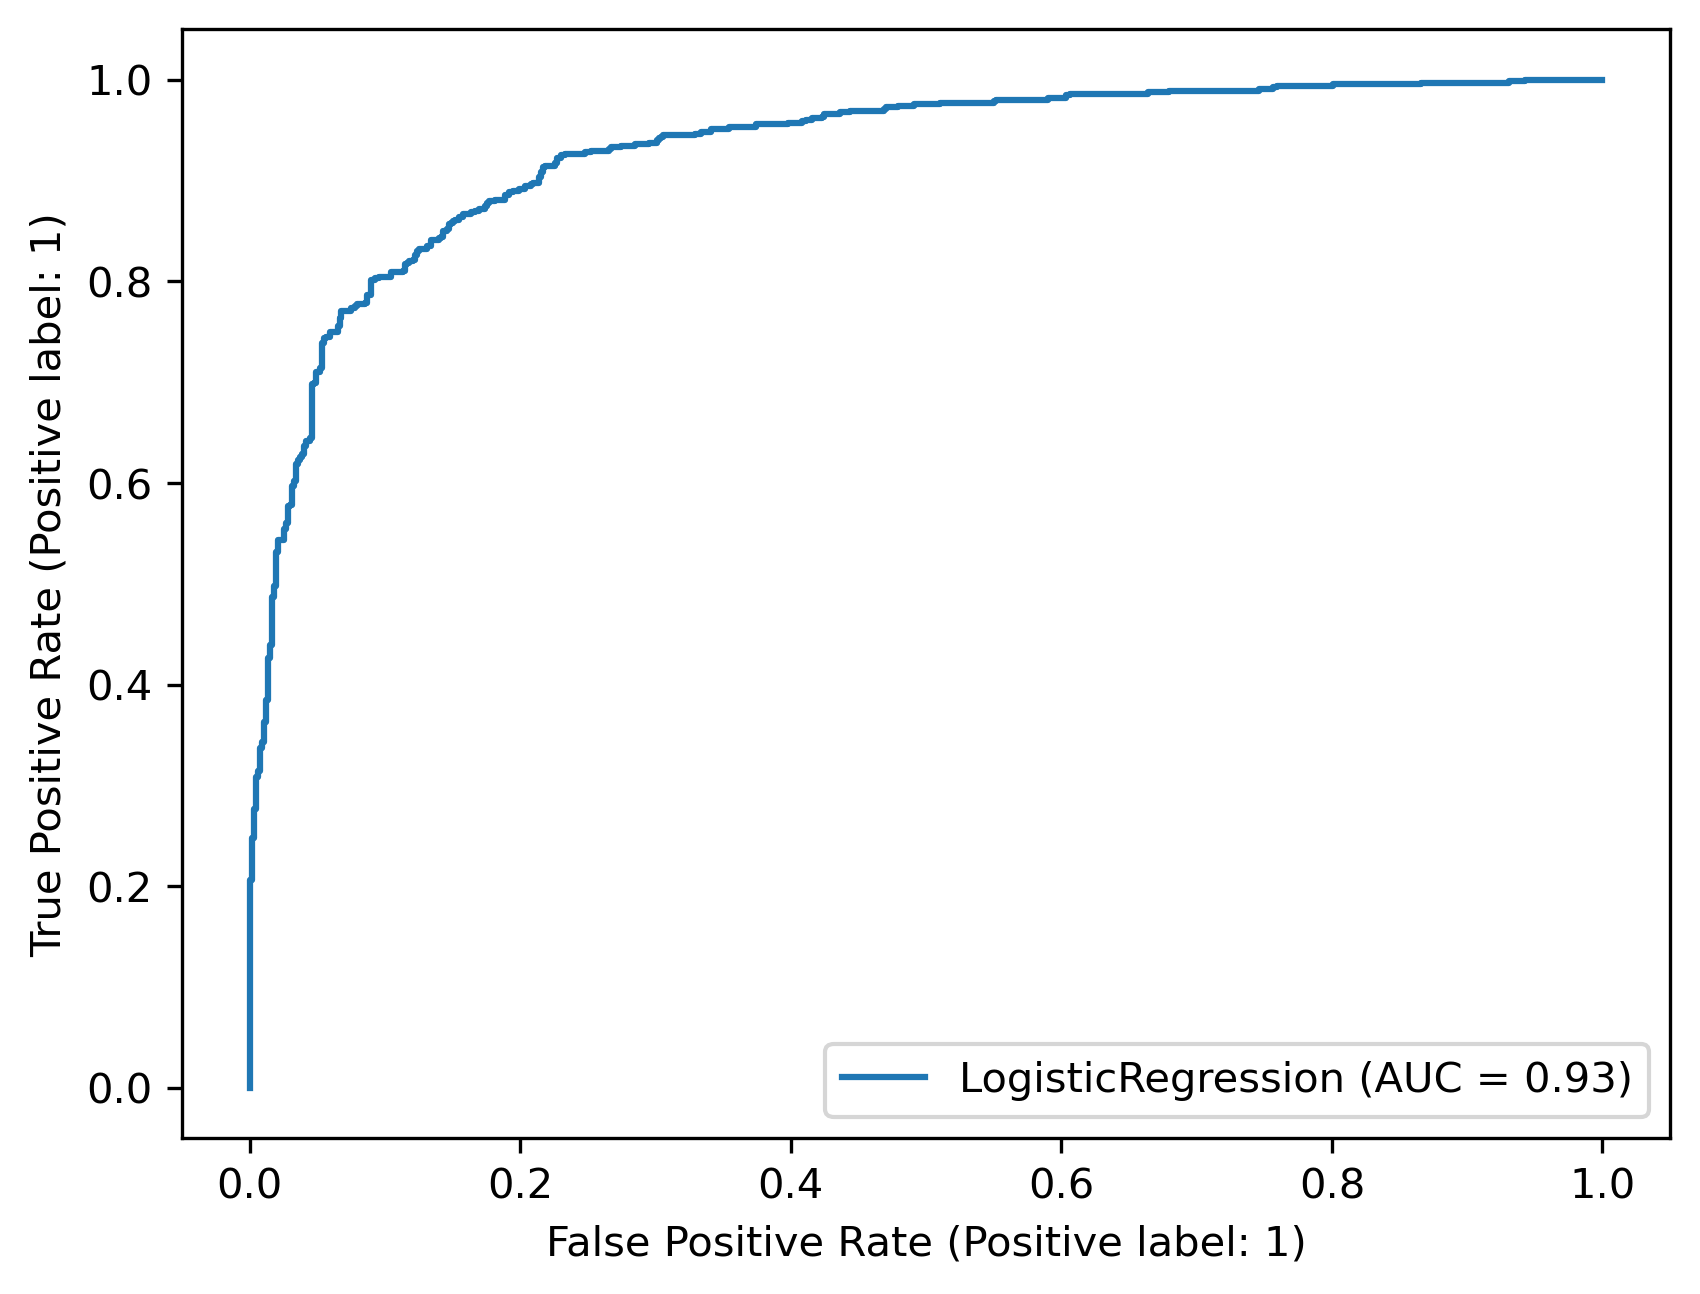

In [42]:
RocCurveDisplay.from_estimator(clf, X_test, y_test)

In [191]:
dot_data = tree.export_graphviz(clf,
                           feature_names=ML_df.columns,
                           proportion=True,
                           precision=2,
                           rounded=True,
                           class_names = ['loss','win'],
                           impurity=False,
                           leaves_parallel=True)
source = Source(dot_data)
source.view()

'Source.gv.pdf'

In [48]:
temp = dict()
for i,j in enumerate(clf.coef_[0]):
    temp[i] = j
{k: v for k, v in sorted(temp.items(), key=lambda item: item[1])}

{24: -0.1725759589674548,
 2: -0.11024361650934003,
 10: -0.09559277121506873,
 53: -0.0927006976470802,
 18: -0.08138188360564602,
 14: -0.07876706415681452,
 58: -0.07729224925498504,
 13: -0.07411156899227289,
 61: -0.07046511608878393,
 68: -0.06461689368393898,
 21: -0.06127760595373012,
 46: -0.059678497744680786,
 17: -0.0544603285858872,
 65: -0.033400758452017364,
 45: -0.0333306759874959,
 54: -0.032748349782838,
 62: -0.0326609776205934,
 37: -0.022900137663412288,
 81: -0.018173291874173898,
 71: -0.016025887963512113,
 28: -0.014931851700582036,
 57: -0.009075091116996614,
 22: -0.00890479686689708,
 79: -0.00830548663448701,
 84: -0.00735989858635102,
 73: -0.007136545623085896,
 32: -0.006736511899033644,
 74: -0.006405477784499412,
 35: -0.005376071387164606,
 40: -0.0044921255915575005,
 27: -0.0038942586936424866,
 83: -0.003138225698132187,
 47: -0.0024064801611525482,
 87: -0.0019379562865603393,
 30: -0.0016615494924986192,
 3: -0.0015573223513631511,
 75: -0.00075

In [174]:
ML_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6661 entries, 0 to 117
Data columns (total 88 columns):
 #   Column                                           Non-Null Count  Dtype  
---  ------                                           --------------  -----  
 0   age                                              6661 non-null   float64
 1   reach                                            6661 non-null   float64
 2   height                                           6661 non-null   float64
 3   prefight_ave_total_comp_time                     6661 non-null   float64
 4   prefight_ave_knockdowns                          6661 non-null   float64
 5   prefight_ave_sub_attempts                        6661 non-null   float64
 6   prefight_ave_reversals                           6661 non-null   float64
 7   prefight_ave_control                             6661 non-null   float64
 8   prefight_ave_takedowns_landed                    6661 non-null   float64
 9   prefight_ave_takedowns_attempts     

In [175]:
accuracy_score(predictions, y_test)

0.8567141785446362